## 데이터 로드 

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation



data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


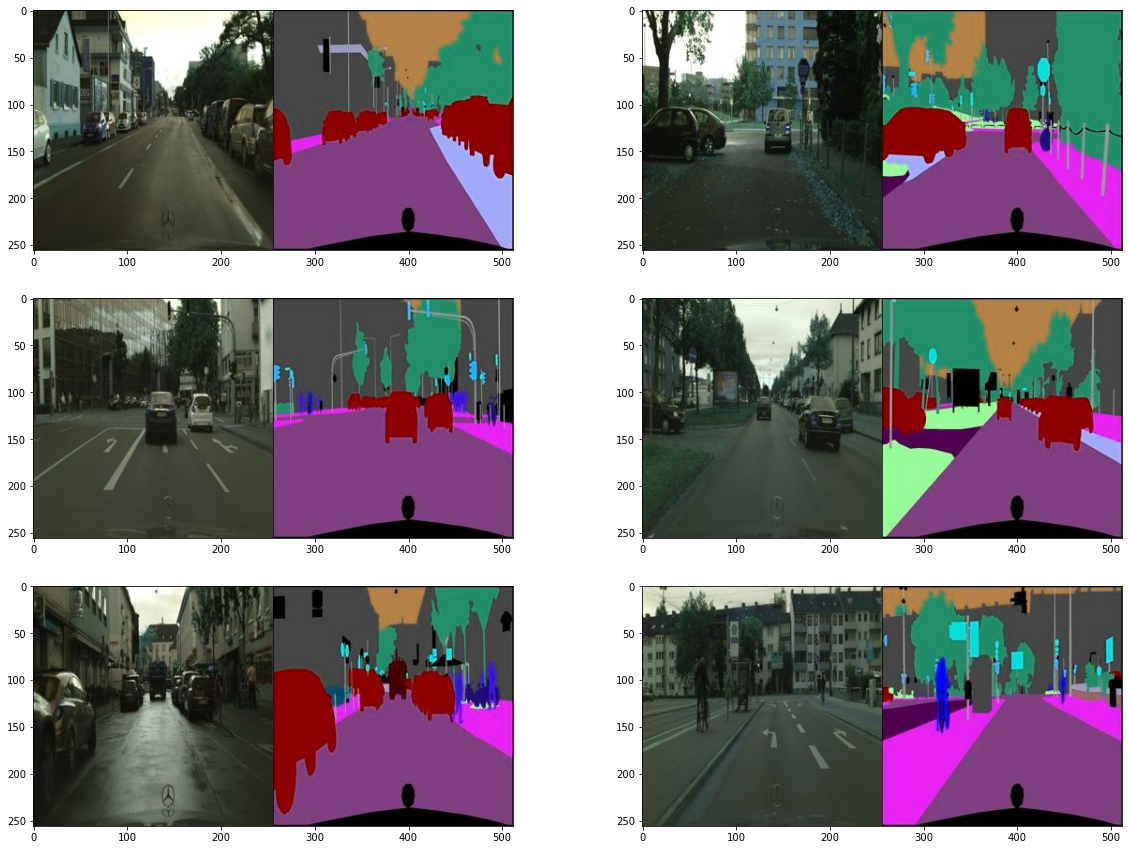

In [2]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


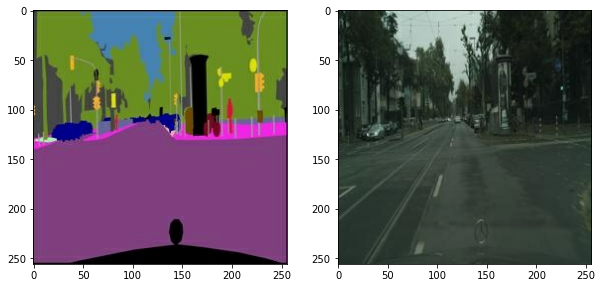

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### Augmentation  
augmentation은 데이터를 부풀려 성능을 확보하는 방법이다.  
> #### 데이터 부풀리기?  
<img src = "https://t1.daumcdn.net/cfile/tistory/99F718445B62CED001">  
이미지 좌우반전  
<img src = "https://t1.daumcdn.net/cfile/tistory/9959F23A5B62CED111">  
이미지 자르기  
<img src = "https://t1.daumcdn.net/cfile/tistory/99149F455B62CED403">  
밝기 조절   

[출처:https://nittaku.tistory.com/272](https://nittaku.tistory.com/272)  
위와 같은 과정을 거쳐서 한 이미지에서 여러개의 데이터를 만들어내는 것을 말한다.

아래 코드는 이미지를 임의로 잘라내고 그 결과를 50% 확률로 가로로, 세로로 뒤집거나 회전 시키는 과정을 담고있다.

In [5]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


apply_augmentation의 결과물을 시각화한 코드

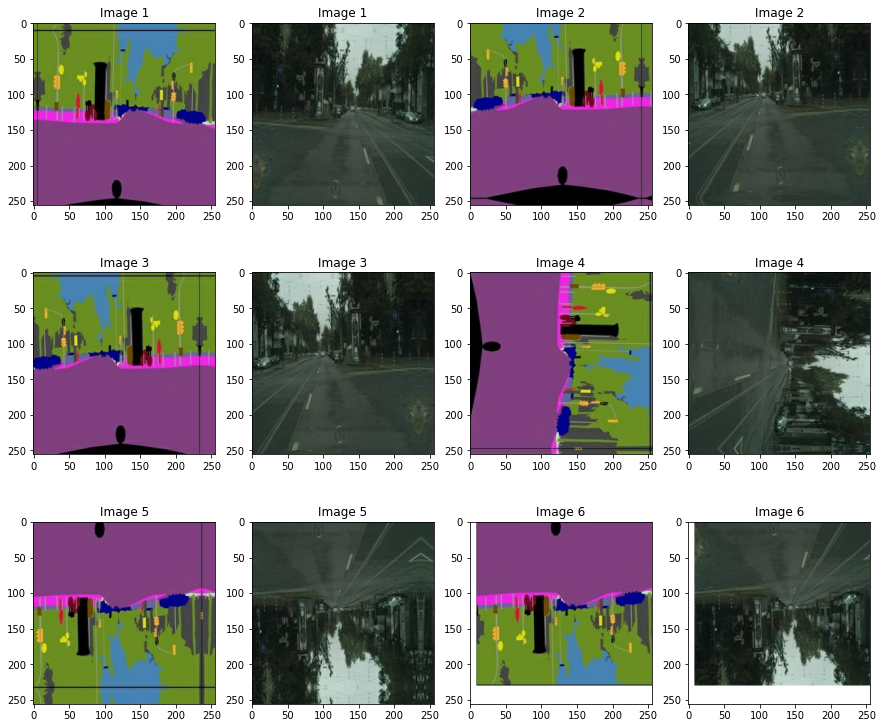

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

이미지에 augmentation이 잘 적용된 것을 볼 수 있다.

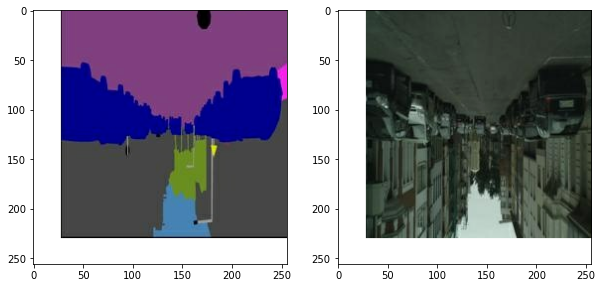

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## Generator 구현 

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


### Encoder 

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

### Decoder 

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

## Encoder-Decoder Gen  
위에서 만들어준 인코더와 디코더를 연결해서 Generator를 만들어준다.

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## U-Net Generator 

In [14]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [15]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

## Discriminator 

In [16]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [17]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [19]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

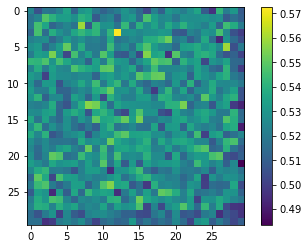

In [20]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 데이터 학습 

In [21]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [22]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [23]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [24]:
EPOCHS = 250

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9334                     
L1_loss:0.3181                     
Discriminator_loss:1.4581

EPOCH[1] - STEP[20]                     
Generator_loss:0.8117                     
L1_loss:0.2761                     
Discriminator_loss:1.3567

EPOCH[1] - STEP[30]                     
Generator_loss:0.8281                     
L1_loss:0.2285                     
Discriminator_loss:1.2455

EPOCH[1] - STEP[40]                     
Generator_loss:0.9186                     
L1_loss:0.1958                     
Discriminator_loss:1.2680

EPOCH[1] - STEP[50]                     
Generator_loss:0.8716                     
L1_loss:0.2031                     
Discriminator_loss:1.4437

EPOCH[1] - STEP[60]                     
Generator_loss:0.8269                     
L1_loss:0.1958                     
Discriminator_loss:1.2062

EPOCH[1] - STEP[70]                     
Generator_loss:1.5006                     
L1_loss:0.2114                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.3866                     
L1_loss:0.1783                     
Discriminator_loss:0.5771

EPOCH[3] - STEP[80]                     
Generator_loss:0.5884                     
L1_loss:0.2317                     
Discriminator_loss:1.0712

EPOCH[3] - STEP[90]                     
Generator_loss:2.3696                     
L1_loss:0.1856                     
Discriminator_loss:0.6857

EPOCH[3] - STEP[100]                     
Generator_loss:1.5912                     
L1_loss:0.2097                     
Discriminator_loss:0.7877

EPOCH[3] - STEP[110]                     
Generator_loss:1.9459                     
L1_loss:0.1450                     
Discriminator_loss:1.2521

EPOCH[3] - STEP[120]                     
Generator_loss:0.3084                     
L1_loss:0.1685                     
Discriminator_loss:1.9256

EPOCH[3] - STEP[130]                     
Generator_loss:1.4012                     
L1_loss:0.1917                

EPOCH[5] - STEP[130]                     
Generator_loss:0.8450                     
L1_loss:0.1656                     
Discriminator_loss:0.7191

EPOCH[5] - STEP[140]                     
Generator_loss:3.2899                     
L1_loss:0.1590                     
Discriminator_loss:1.1617

EPOCH[5] - STEP[150]                     
Generator_loss:0.9237                     
L1_loss:0.2175                     
Discriminator_loss:0.7616

EPOCH[5] - STEP[160]                     
Generator_loss:1.2847                     
L1_loss:0.1910                     
Discriminator_loss:1.1104

EPOCH[5] - STEP[170]                     
Generator_loss:1.8412                     
L1_loss:0.2222                     
Discriminator_loss:0.2882

EPOCH[5] - STEP[180]                     
Generator_loss:2.2651                     
L1_loss:0.1904                     
Discriminator_loss:0.5099

EPOCH[5] - STEP[190]                     
Generator_loss:1.8418                     
L1_loss:0.1626             

EPOCH[7] - STEP[190]                     
Generator_loss:0.6860                     
L1_loss:0.1573                     
Discriminator_loss:1.3291

EPOCH[7] - STEP[200]                     
Generator_loss:1.0774                     
L1_loss:0.1803                     
Discriminator_loss:0.7232

EPOCH[7] - STEP[210]                     
Generator_loss:1.5245                     
L1_loss:0.1657                     
Discriminator_loss:0.7379

EPOCH[7] - STEP[220]                     
Generator_loss:1.0425                     
L1_loss:0.1820                     
Discriminator_loss:0.9451

EPOCH[7] - STEP[230]                     
Generator_loss:0.8505                     
L1_loss:0.2190                     
Discriminator_loss:0.8869

EPOCH[7] - STEP[240]                     
Generator_loss:2.4114                     
L1_loss:0.1789                     
Discriminator_loss:1.0006

EPOCH[7] - STEP[250]                     
Generator_loss:1.9452                     
L1_loss:0.1741             

EPOCH[9] - STEP[250]                     
Generator_loss:1.9672                     
L1_loss:0.1585                     
Discriminator_loss:0.8247

EPOCH[10] - STEP[10]                     
Generator_loss:1.7120                     
L1_loss:0.1607                     
Discriminator_loss:0.5996

EPOCH[10] - STEP[20]                     
Generator_loss:1.4691                     
L1_loss:0.1617                     
Discriminator_loss:0.5918

EPOCH[10] - STEP[30]                     
Generator_loss:1.4791                     
L1_loss:0.2020                     
Discriminator_loss:0.3271

EPOCH[10] - STEP[40]                     
Generator_loss:0.9817                     
L1_loss:0.2206                     
Discriminator_loss:0.5808

EPOCH[10] - STEP[50]                     
Generator_loss:0.9978                     
L1_loss:0.1873                     
Discriminator_loss:0.5878

EPOCH[10] - STEP[60]                     
Generator_loss:1.7596                     
L1_loss:0.1676             

EPOCH[12] - STEP[60]                     
Generator_loss:0.8770                     
L1_loss:0.1776                     
Discriminator_loss:1.0021

EPOCH[12] - STEP[70]                     
Generator_loss:1.0949                     
L1_loss:0.1820                     
Discriminator_loss:1.1179

EPOCH[12] - STEP[80]                     
Generator_loss:0.9258                     
L1_loss:0.1902                     
Discriminator_loss:0.7592

EPOCH[12] - STEP[90]                     
Generator_loss:1.8022                     
L1_loss:0.1796                     
Discriminator_loss:0.6892

EPOCH[12] - STEP[100]                     
Generator_loss:2.0974                     
L1_loss:0.1618                     
Discriminator_loss:0.6621

EPOCH[12] - STEP[110]                     
Generator_loss:2.1952                     
L1_loss:0.1653                     
Discriminator_loss:0.4432

EPOCH[12] - STEP[120]                     
Generator_loss:1.7980                     
L1_loss:0.1846          

EPOCH[14] - STEP[120]                     
Generator_loss:2.0597                     
L1_loss:0.1789                     
Discriminator_loss:0.7634

EPOCH[14] - STEP[130]                     
Generator_loss:0.7041                     
L1_loss:0.1806                     
Discriminator_loss:0.9988

EPOCH[14] - STEP[140]                     
Generator_loss:1.2457                     
L1_loss:0.1784                     
Discriminator_loss:0.6355

EPOCH[14] - STEP[150]                     
Generator_loss:2.5685                     
L1_loss:0.1779                     
Discriminator_loss:0.1990

EPOCH[14] - STEP[160]                     
Generator_loss:1.7505                     
L1_loss:0.2258                     
Discriminator_loss:0.2285

EPOCH[14] - STEP[170]                     
Generator_loss:1.3871                     
L1_loss:0.1755                     
Discriminator_loss:0.9734

EPOCH[14] - STEP[180]                     
Generator_loss:1.1231                     
L1_loss:0.1688      

EPOCH[16] - STEP[180]                     
Generator_loss:0.8765                     
L1_loss:0.1979                     
Discriminator_loss:1.0459

EPOCH[16] - STEP[190]                     
Generator_loss:0.9749                     
L1_loss:0.1350                     
Discriminator_loss:1.1483

EPOCH[16] - STEP[200]                     
Generator_loss:0.8257                     
L1_loss:0.1939                     
Discriminator_loss:0.6998

EPOCH[16] - STEP[210]                     
Generator_loss:1.0642                     
L1_loss:0.1940                     
Discriminator_loss:0.9007

EPOCH[16] - STEP[220]                     
Generator_loss:1.2233                     
L1_loss:0.1562                     
Discriminator_loss:0.9778

EPOCH[16] - STEP[230]                     
Generator_loss:1.0153                     
L1_loss:0.1718                     
Discriminator_loss:1.0135

EPOCH[16] - STEP[240]                     
Generator_loss:1.3680                     
L1_loss:0.1627      

EPOCH[18] - STEP[240]                     
Generator_loss:0.7164                     
L1_loss:0.1713                     
Discriminator_loss:0.9055

EPOCH[18] - STEP[250]                     
Generator_loss:1.1864                     
L1_loss:0.1624                     
Discriminator_loss:1.4874

EPOCH[19] - STEP[10]                     
Generator_loss:2.1072                     
L1_loss:0.1569                     
Discriminator_loss:0.7249

EPOCH[19] - STEP[20]                     
Generator_loss:0.9551                     
L1_loss:0.1785                     
Discriminator_loss:0.6331

EPOCH[19] - STEP[30]                     
Generator_loss:1.5185                     
L1_loss:0.2084                     
Discriminator_loss:0.2990

EPOCH[19] - STEP[40]                     
Generator_loss:1.1805                     
L1_loss:0.1640                     
Discriminator_loss:1.0946

EPOCH[19] - STEP[50]                     
Generator_loss:1.0590                     
L1_loss:0.1745           

EPOCH[21] - STEP[50]                     
Generator_loss:2.0170                     
L1_loss:0.1927                     
Discriminator_loss:0.4779

EPOCH[21] - STEP[60]                     
Generator_loss:2.0258                     
L1_loss:0.1347                     
Discriminator_loss:1.4632

EPOCH[21] - STEP[70]                     
Generator_loss:1.7697                     
L1_loss:0.1916                     
Discriminator_loss:0.5824

EPOCH[21] - STEP[80]                     
Generator_loss:0.5085                     
L1_loss:0.1831                     
Discriminator_loss:1.1331

EPOCH[21] - STEP[90]                     
Generator_loss:1.2970                     
L1_loss:0.1889                     
Discriminator_loss:0.4434

EPOCH[21] - STEP[100]                     
Generator_loss:2.2753                     
L1_loss:0.1790                     
Discriminator_loss:0.7477

EPOCH[21] - STEP[110]                     
Generator_loss:1.4340                     
L1_loss:0.2337           

EPOCH[23] - STEP[110]                     
Generator_loss:1.8935                     
L1_loss:0.1551                     
Discriminator_loss:1.1418

EPOCH[23] - STEP[120]                     
Generator_loss:1.8986                     
L1_loss:0.1666                     
Discriminator_loss:1.4326

EPOCH[23] - STEP[130]                     
Generator_loss:1.1161                     
L1_loss:0.1903                     
Discriminator_loss:1.5997

EPOCH[23] - STEP[140]                     
Generator_loss:2.1084                     
L1_loss:0.1442                     
Discriminator_loss:1.5963

EPOCH[23] - STEP[150]                     
Generator_loss:2.0344                     
L1_loss:0.1602                     
Discriminator_loss:1.3440

EPOCH[23] - STEP[160]                     
Generator_loss:0.6251                     
L1_loss:0.2314                     
Discriminator_loss:0.9071

EPOCH[23] - STEP[170]                     
Generator_loss:1.3590                     
L1_loss:0.1921      

EPOCH[25] - STEP[170]                     
Generator_loss:1.1446                     
L1_loss:0.1723                     
Discriminator_loss:0.6334

EPOCH[25] - STEP[180]                     
Generator_loss:1.0779                     
L1_loss:0.1887                     
Discriminator_loss:0.4596

EPOCH[25] - STEP[190]                     
Generator_loss:1.9713                     
L1_loss:0.1485                     
Discriminator_loss:1.4304

EPOCH[25] - STEP[200]                     
Generator_loss:1.0405                     
L1_loss:0.1419                     
Discriminator_loss:1.4950

EPOCH[25] - STEP[210]                     
Generator_loss:1.0441                     
L1_loss:0.1979                     
Discriminator_loss:0.9680

EPOCH[25] - STEP[220]                     
Generator_loss:1.7492                     
L1_loss:0.1499                     
Discriminator_loss:1.6406

EPOCH[25] - STEP[230]                     
Generator_loss:3.0440                     
L1_loss:0.1408      

EPOCH[27] - STEP[230]                     
Generator_loss:0.5838                     
L1_loss:0.1779                     
Discriminator_loss:1.0667

EPOCH[27] - STEP[240]                     
Generator_loss:0.7121                     
L1_loss:0.1806                     
Discriminator_loss:0.8219

EPOCH[27] - STEP[250]                     
Generator_loss:1.4258                     
L1_loss:0.1881                     
Discriminator_loss:0.5897

EPOCH[28] - STEP[10]                     
Generator_loss:1.4672                     
L1_loss:0.1576                     
Discriminator_loss:0.5652

EPOCH[28] - STEP[20]                     
Generator_loss:0.4890                     
L1_loss:0.1747                     
Discriminator_loss:1.3861

EPOCH[28] - STEP[30]                     
Generator_loss:1.3014                     
L1_loss:0.1672                     
Discriminator_loss:0.8492

EPOCH[28] - STEP[40]                     
Generator_loss:2.4760                     
L1_loss:0.1640          

EPOCH[30] - STEP[40]                     
Generator_loss:2.2366                     
L1_loss:0.1761                     
Discriminator_loss:1.5191

EPOCH[30] - STEP[50]                     
Generator_loss:1.5031                     
L1_loss:0.1721                     
Discriminator_loss:0.7657

EPOCH[30] - STEP[60]                     
Generator_loss:2.1428                     
L1_loss:0.1751                     
Discriminator_loss:1.3979

EPOCH[30] - STEP[70]                     
Generator_loss:2.6030                     
L1_loss:0.1516                     
Discriminator_loss:1.9263

EPOCH[30] - STEP[80]                     
Generator_loss:0.2214                     
L1_loss:0.1837                     
Discriminator_loss:1.8354

EPOCH[30] - STEP[90]                     
Generator_loss:1.1255                     
L1_loss:0.1399                     
Discriminator_loss:1.1455

EPOCH[30] - STEP[100]                     
Generator_loss:2.0497                     
L1_loss:0.1630            

EPOCH[32] - STEP[100]                     
Generator_loss:1.9547                     
L1_loss:0.1508                     
Discriminator_loss:1.4782

EPOCH[32] - STEP[110]                     
Generator_loss:1.7009                     
L1_loss:0.1830                     
Discriminator_loss:1.6786

EPOCH[32] - STEP[120]                     
Generator_loss:0.5008                     
L1_loss:0.1630                     
Discriminator_loss:1.1963

EPOCH[32] - STEP[130]                     
Generator_loss:2.0607                     
L1_loss:0.1506                     
Discriminator_loss:0.8399

EPOCH[32] - STEP[140]                     
Generator_loss:0.4081                     
L1_loss:0.2160                     
Discriminator_loss:2.6443

EPOCH[32] - STEP[150]                     
Generator_loss:1.2997                     
L1_loss:0.1710                     
Discriminator_loss:1.1464

EPOCH[32] - STEP[160]                     
Generator_loss:1.9267                     
L1_loss:0.1608      

EPOCH[34] - STEP[160]                     
Generator_loss:1.1221                     
L1_loss:0.1798                     
Discriminator_loss:1.3073

EPOCH[34] - STEP[170]                     
Generator_loss:0.8582                     
L1_loss:0.1748                     
Discriminator_loss:1.5766

EPOCH[34] - STEP[180]                     
Generator_loss:1.2662                     
L1_loss:0.1819                     
Discriminator_loss:0.4506

EPOCH[34] - STEP[190]                     
Generator_loss:1.5194                     
L1_loss:0.1573                     
Discriminator_loss:0.9693

EPOCH[34] - STEP[200]                     
Generator_loss:0.9787                     
L1_loss:0.1508                     
Discriminator_loss:0.9834

EPOCH[34] - STEP[210]                     
Generator_loss:0.9159                     
L1_loss:0.1595                     
Discriminator_loss:1.1299

EPOCH[34] - STEP[220]                     
Generator_loss:1.3124                     
L1_loss:0.1797      

EPOCH[36] - STEP[220]                     
Generator_loss:2.1139                     
L1_loss:0.1649                     
Discriminator_loss:1.1429

EPOCH[36] - STEP[230]                     
Generator_loss:1.5385                     
L1_loss:0.1720                     
Discriminator_loss:0.3823

EPOCH[36] - STEP[240]                     
Generator_loss:1.9449                     
L1_loss:0.1849                     
Discriminator_loss:0.2861

EPOCH[36] - STEP[250]                     
Generator_loss:1.3060                     
L1_loss:0.1855                     
Discriminator_loss:0.5794

EPOCH[37] - STEP[10]                     
Generator_loss:1.8326                     
L1_loss:0.1544                     
Discriminator_loss:0.8769

EPOCH[37] - STEP[20]                     
Generator_loss:1.5039                     
L1_loss:0.2045                     
Discriminator_loss:0.4042

EPOCH[37] - STEP[30]                     
Generator_loss:1.5507                     
L1_loss:0.1606         

EPOCH[39] - STEP[30]                     
Generator_loss:0.9748                     
L1_loss:0.1586                     
Discriminator_loss:1.2968

EPOCH[39] - STEP[40]                     
Generator_loss:2.0632                     
L1_loss:0.1942                     
Discriminator_loss:0.3240

EPOCH[39] - STEP[50]                     
Generator_loss:1.2265                     
L1_loss:0.1579                     
Discriminator_loss:0.7475

EPOCH[39] - STEP[60]                     
Generator_loss:0.9997                     
L1_loss:0.1740                     
Discriminator_loss:0.7310

EPOCH[39] - STEP[70]                     
Generator_loss:1.6866                     
L1_loss:0.1987                     
Discriminator_loss:0.9647

EPOCH[39] - STEP[80]                     
Generator_loss:2.9759                     
L1_loss:0.1681                     
Discriminator_loss:2.0753

EPOCH[39] - STEP[90]                     
Generator_loss:1.2673                     
L1_loss:0.2012             

EPOCH[41] - STEP[90]                     
Generator_loss:1.6493                     
L1_loss:0.1742                     
Discriminator_loss:1.1962

EPOCH[41] - STEP[100]                     
Generator_loss:0.8788                     
L1_loss:0.1735                     
Discriminator_loss:1.2923

EPOCH[41] - STEP[110]                     
Generator_loss:1.9394                     
L1_loss:0.1530                     
Discriminator_loss:0.4152

EPOCH[41] - STEP[120]                     
Generator_loss:0.6965                     
L1_loss:0.1549                     
Discriminator_loss:0.8429

EPOCH[41] - STEP[130]                     
Generator_loss:1.4179                     
L1_loss:0.1495                     
Discriminator_loss:0.5708

EPOCH[41] - STEP[140]                     
Generator_loss:1.9320                     
L1_loss:0.1419                     
Discriminator_loss:1.4055

EPOCH[41] - STEP[150]                     
Generator_loss:0.9243                     
L1_loss:0.1978       

EPOCH[43] - STEP[150]                     
Generator_loss:1.2785                     
L1_loss:0.1718                     
Discriminator_loss:0.8628

EPOCH[43] - STEP[160]                     
Generator_loss:2.7196                     
L1_loss:0.1603                     
Discriminator_loss:0.6018

EPOCH[43] - STEP[170]                     
Generator_loss:1.7798                     
L1_loss:0.1575                     
Discriminator_loss:1.2493

EPOCH[43] - STEP[180]                     
Generator_loss:0.6241                     
L1_loss:0.1823                     
Discriminator_loss:1.3126

EPOCH[43] - STEP[190]                     
Generator_loss:1.8340                     
L1_loss:0.1716                     
Discriminator_loss:0.5910

EPOCH[43] - STEP[200]                     
Generator_loss:0.4872                     
L1_loss:0.1839                     
Discriminator_loss:1.2177

EPOCH[43] - STEP[210]                     
Generator_loss:2.5150                     
L1_loss:0.1831      

EPOCH[45] - STEP[210]                     
Generator_loss:2.3311                     
L1_loss:0.1906                     
Discriminator_loss:0.3556

EPOCH[45] - STEP[220]                     
Generator_loss:2.1021                     
L1_loss:0.1939                     
Discriminator_loss:0.2485

EPOCH[45] - STEP[230]                     
Generator_loss:1.1468                     
L1_loss:0.1783                     
Discriminator_loss:0.6121

EPOCH[45] - STEP[240]                     
Generator_loss:0.3345                     
L1_loss:0.1772                     
Discriminator_loss:1.4437

EPOCH[45] - STEP[250]                     
Generator_loss:1.2027                     
L1_loss:0.1742                     
Discriminator_loss:0.5654

EPOCH[46] - STEP[10]                     
Generator_loss:1.7168                     
L1_loss:0.1809                     
Discriminator_loss:0.3748

EPOCH[46] - STEP[20]                     
Generator_loss:1.5531                     
L1_loss:0.2048        

EPOCH[48] - STEP[20]                     
Generator_loss:2.5321                     
L1_loss:0.1538                     
Discriminator_loss:0.9724

EPOCH[48] - STEP[30]                     
Generator_loss:1.3507                     
L1_loss:0.1740                     
Discriminator_loss:0.7262

EPOCH[48] - STEP[40]                     
Generator_loss:0.7333                     
L1_loss:0.1948                     
Discriminator_loss:0.8977

EPOCH[48] - STEP[50]                     
Generator_loss:0.8067                     
L1_loss:0.1694                     
Discriminator_loss:1.0506

EPOCH[48] - STEP[60]                     
Generator_loss:1.9529                     
L1_loss:0.1996                     
Discriminator_loss:0.2396

EPOCH[48] - STEP[70]                     
Generator_loss:2.4983                     
L1_loss:0.1725                     
Discriminator_loss:0.3472

EPOCH[48] - STEP[80]                     
Generator_loss:0.5372                     
L1_loss:0.1894             

EPOCH[50] - STEP[80]                     
Generator_loss:2.8486                     
L1_loss:0.1635                     
Discriminator_loss:1.7930

EPOCH[50] - STEP[90]                     
Generator_loss:1.6380                     
L1_loss:0.1592                     
Discriminator_loss:0.4504

EPOCH[50] - STEP[100]                     
Generator_loss:0.5998                     
L1_loss:0.1684                     
Discriminator_loss:1.6924

EPOCH[50] - STEP[110]                     
Generator_loss:1.0662                     
L1_loss:0.1473                     
Discriminator_loss:1.3770

EPOCH[50] - STEP[120]                     
Generator_loss:1.3316                     
L1_loss:0.2002                     
Discriminator_loss:1.0903

EPOCH[50] - STEP[130]                     
Generator_loss:1.1370                     
L1_loss:0.1644                     
Discriminator_loss:0.7027

EPOCH[50] - STEP[140]                     
Generator_loss:1.3843                     
L1_loss:0.2014        

EPOCH[52] - STEP[140]                     
Generator_loss:1.7493                     
L1_loss:0.1831                     
Discriminator_loss:0.4772

EPOCH[52] - STEP[150]                     
Generator_loss:0.7310                     
L1_loss:0.2074                     
Discriminator_loss:0.7675

EPOCH[52] - STEP[160]                     
Generator_loss:1.4545                     
L1_loss:0.1619                     
Discriminator_loss:0.9661

EPOCH[52] - STEP[170]                     
Generator_loss:1.5544                     
L1_loss:0.1775                     
Discriminator_loss:0.3945

EPOCH[52] - STEP[180]                     
Generator_loss:0.8752                     
L1_loss:0.1626                     
Discriminator_loss:0.7046

EPOCH[52] - STEP[190]                     
Generator_loss:1.5264                     
L1_loss:0.1538                     
Discriminator_loss:1.6284

EPOCH[52] - STEP[200]                     
Generator_loss:1.9230                     
L1_loss:0.1749      

EPOCH[54] - STEP[200]                     
Generator_loss:1.9307                     
L1_loss:0.1727                     
Discriminator_loss:1.3794

EPOCH[54] - STEP[210]                     
Generator_loss:2.5544                     
L1_loss:0.1521                     
Discriminator_loss:0.7225

EPOCH[54] - STEP[220]                     
Generator_loss:0.7592                     
L1_loss:0.1571                     
Discriminator_loss:1.2000

EPOCH[54] - STEP[230]                     
Generator_loss:1.6760                     
L1_loss:0.1829                     
Discriminator_loss:0.3029

EPOCH[54] - STEP[240]                     
Generator_loss:1.4526                     
L1_loss:0.1579                     
Discriminator_loss:0.7066

EPOCH[54] - STEP[250]                     
Generator_loss:1.0534                     
L1_loss:0.1920                     
Discriminator_loss:0.6287

EPOCH[55] - STEP[10]                     
Generator_loss:0.4288                     
L1_loss:0.1572       

EPOCH[57] - STEP[10]                     
Generator_loss:1.6405                     
L1_loss:0.1627                     
Discriminator_loss:1.8241

EPOCH[57] - STEP[20]                     
Generator_loss:3.1446                     
L1_loss:0.1360                     
Discriminator_loss:2.4007

EPOCH[57] - STEP[30]                     
Generator_loss:2.3071                     
L1_loss:0.1690                     
Discriminator_loss:2.1205

EPOCH[57] - STEP[40]                     
Generator_loss:0.4882                     
L1_loss:0.1854                     
Discriminator_loss:1.1977

EPOCH[57] - STEP[50]                     
Generator_loss:1.5825                     
L1_loss:0.1778                     
Discriminator_loss:0.3542

EPOCH[57] - STEP[60]                     
Generator_loss:1.0653                     
L1_loss:0.1605                     
Discriminator_loss:1.4833

EPOCH[57] - STEP[70]                     
Generator_loss:2.5054                     
L1_loss:0.1749             

EPOCH[59] - STEP[70]                     
Generator_loss:1.2751                     
L1_loss:0.1514                     
Discriminator_loss:0.8141

EPOCH[59] - STEP[80]                     
Generator_loss:1.4952                     
L1_loss:0.1786                     
Discriminator_loss:0.4811

EPOCH[59] - STEP[90]                     
Generator_loss:1.3067                     
L1_loss:0.1550                     
Discriminator_loss:0.8364

EPOCH[59] - STEP[100]                     
Generator_loss:0.8507                     
L1_loss:0.1767                     
Discriminator_loss:0.9756

EPOCH[59] - STEP[110]                     
Generator_loss:0.5953                     
L1_loss:0.1597                     
Discriminator_loss:1.5702

EPOCH[59] - STEP[120]                     
Generator_loss:0.5673                     
L1_loss:0.1681                     
Discriminator_loss:1.0847

EPOCH[59] - STEP[130]                     
Generator_loss:1.0778                     
L1_loss:0.1825         

EPOCH[61] - STEP[130]                     
Generator_loss:1.3332                     
L1_loss:0.1925                     
Discriminator_loss:0.4690

EPOCH[61] - STEP[140]                     
Generator_loss:1.8965                     
L1_loss:0.1629                     
Discriminator_loss:0.3318

EPOCH[61] - STEP[150]                     
Generator_loss:0.4824                     
L1_loss:0.2036                     
Discriminator_loss:1.2858

EPOCH[61] - STEP[160]                     
Generator_loss:1.2617                     
L1_loss:0.1691                     
Discriminator_loss:1.0390

EPOCH[61] - STEP[170]                     
Generator_loss:1.6870                     
L1_loss:0.1442                     
Discriminator_loss:1.0353

EPOCH[61] - STEP[180]                     
Generator_loss:0.8574                     
L1_loss:0.2055                     
Discriminator_loss:0.6820

EPOCH[61] - STEP[190]                     
Generator_loss:1.8400                     
L1_loss:0.1731      

EPOCH[63] - STEP[190]                     
Generator_loss:1.2794                     
L1_loss:0.1637                     
Discriminator_loss:0.9941

EPOCH[63] - STEP[200]                     
Generator_loss:2.1645                     
L1_loss:0.1404                     
Discriminator_loss:2.0378

EPOCH[63] - STEP[210]                     
Generator_loss:1.3624                     
L1_loss:0.1706                     
Discriminator_loss:1.0625

EPOCH[63] - STEP[220]                     
Generator_loss:1.3561                     
L1_loss:0.1718                     
Discriminator_loss:1.3691

EPOCH[63] - STEP[230]                     
Generator_loss:1.7260                     
L1_loss:0.1829                     
Discriminator_loss:0.3808

EPOCH[63] - STEP[240]                     
Generator_loss:1.4525                     
L1_loss:0.1621                     
Discriminator_loss:0.9255

EPOCH[63] - STEP[250]                     
Generator_loss:1.3554                     
L1_loss:0.1819      

EPOCH[65] - STEP[250]                     
Generator_loss:2.0201                     
L1_loss:0.2025                     
Discriminator_loss:0.5760

EPOCH[66] - STEP[10]                     
Generator_loss:1.6811                     
L1_loss:0.2252                     
Discriminator_loss:0.2874

EPOCH[66] - STEP[20]                     
Generator_loss:1.2623                     
L1_loss:0.1617                     
Discriminator_loss:0.7729

EPOCH[66] - STEP[30]                     
Generator_loss:0.5583                     
L1_loss:0.1741                     
Discriminator_loss:1.0373

EPOCH[66] - STEP[40]                     
Generator_loss:1.5856                     
L1_loss:0.1820                     
Discriminator_loss:0.4600

EPOCH[66] - STEP[50]                     
Generator_loss:1.9081                     
L1_loss:0.1611                     
Discriminator_loss:2.1058

EPOCH[66] - STEP[60]                     
Generator_loss:0.7583                     
L1_loss:0.2170            

EPOCH[68] - STEP[60]                     
Generator_loss:1.5212                     
L1_loss:0.1541                     
Discriminator_loss:0.5177

EPOCH[68] - STEP[70]                     
Generator_loss:0.8497                     
L1_loss:0.1562                     
Discriminator_loss:0.7191

EPOCH[68] - STEP[80]                     
Generator_loss:1.6149                     
L1_loss:0.1650                     
Discriminator_loss:0.6714

EPOCH[68] - STEP[90]                     
Generator_loss:0.7404                     
L1_loss:0.1821                     
Discriminator_loss:1.3335

EPOCH[68] - STEP[100]                     
Generator_loss:1.4762                     
L1_loss:0.1625                     
Discriminator_loss:0.7601

EPOCH[68] - STEP[110]                     
Generator_loss:2.2307                     
L1_loss:0.1704                     
Discriminator_loss:1.1767

EPOCH[68] - STEP[120]                     
Generator_loss:1.1136                     
L1_loss:0.1729          

EPOCH[70] - STEP[120]                     
Generator_loss:1.7664                     
L1_loss:0.1583                     
Discriminator_loss:2.0112

EPOCH[70] - STEP[130]                     
Generator_loss:1.5524                     
L1_loss:0.2199                     
Discriminator_loss:0.2879

EPOCH[70] - STEP[140]                     
Generator_loss:1.6431                     
L1_loss:0.1602                     
Discriminator_loss:0.5493

EPOCH[70] - STEP[150]                     
Generator_loss:1.4330                     
L1_loss:0.1694                     
Discriminator_loss:0.3743

EPOCH[70] - STEP[160]                     
Generator_loss:0.8221                     
L1_loss:0.1770                     
Discriminator_loss:1.2574

EPOCH[70] - STEP[170]                     
Generator_loss:1.9598                     
L1_loss:0.1551                     
Discriminator_loss:1.2912

EPOCH[70] - STEP[180]                     
Generator_loss:1.4380                     
L1_loss:0.1788      

EPOCH[72] - STEP[180]                     
Generator_loss:0.9319                     
L1_loss:0.1843                     
Discriminator_loss:0.6895

EPOCH[72] - STEP[190]                     
Generator_loss:1.1324                     
L1_loss:0.1776                     
Discriminator_loss:0.9685

EPOCH[72] - STEP[200]                     
Generator_loss:2.7195                     
L1_loss:0.2017                     
Discriminator_loss:0.2237

EPOCH[72] - STEP[210]                     
Generator_loss:3.1029                     
L1_loss:0.1924                     
Discriminator_loss:0.8385

EPOCH[72] - STEP[220]                     
Generator_loss:0.6187                     
L1_loss:0.1835                     
Discriminator_loss:0.9524

EPOCH[72] - STEP[230]                     
Generator_loss:2.0668                     
L1_loss:0.1615                     
Discriminator_loss:0.5702

EPOCH[72] - STEP[240]                     
Generator_loss:2.3747                     
L1_loss:0.1752      

EPOCH[74] - STEP[240]                     
Generator_loss:0.9115                     
L1_loss:0.1835                     
Discriminator_loss:0.8121

EPOCH[74] - STEP[250]                     
Generator_loss:0.8700                     
L1_loss:0.1696                     
Discriminator_loss:0.7254

EPOCH[75] - STEP[10]                     
Generator_loss:1.6171                     
L1_loss:0.1823                     
Discriminator_loss:0.4354

EPOCH[75] - STEP[20]                     
Generator_loss:1.1345                     
L1_loss:0.1655                     
Discriminator_loss:0.5148

EPOCH[75] - STEP[30]                     
Generator_loss:1.6170                     
L1_loss:0.1820                     
Discriminator_loss:0.3200

EPOCH[75] - STEP[40]                     
Generator_loss:1.7174                     
L1_loss:0.1681                     
Discriminator_loss:0.9778

EPOCH[75] - STEP[50]                     
Generator_loss:1.4679                     
L1_loss:0.1781           

EPOCH[77] - STEP[50]                     
Generator_loss:0.3747                     
L1_loss:0.1684                     
Discriminator_loss:1.9292

EPOCH[77] - STEP[60]                     
Generator_loss:1.9129                     
L1_loss:0.1977                     
Discriminator_loss:0.6697

EPOCH[77] - STEP[70]                     
Generator_loss:0.4539                     
L1_loss:0.1657                     
Discriminator_loss:1.1825

EPOCH[77] - STEP[80]                     
Generator_loss:1.1135                     
L1_loss:0.1452                     
Discriminator_loss:1.0318

EPOCH[77] - STEP[90]                     
Generator_loss:1.4927                     
L1_loss:0.1597                     
Discriminator_loss:1.9583

EPOCH[77] - STEP[100]                     
Generator_loss:2.1389                     
L1_loss:0.1809                     
Discriminator_loss:0.4568

EPOCH[77] - STEP[110]                     
Generator_loss:2.8912                     
L1_loss:0.1677           

EPOCH[79] - STEP[110]                     
Generator_loss:0.8752                     
L1_loss:0.1906                     
Discriminator_loss:0.7518

EPOCH[79] - STEP[120]                     
Generator_loss:1.7756                     
L1_loss:0.1606                     
Discriminator_loss:1.4048

EPOCH[79] - STEP[130]                     
Generator_loss:1.7992                     
L1_loss:0.1737                     
Discriminator_loss:0.7414

EPOCH[79] - STEP[140]                     
Generator_loss:1.8662                     
L1_loss:0.1452                     
Discriminator_loss:1.0880

EPOCH[79] - STEP[150]                     
Generator_loss:1.2159                     
L1_loss:0.1851                     
Discriminator_loss:0.6854

EPOCH[79] - STEP[160]                     
Generator_loss:2.0708                     
L1_loss:0.1730                     
Discriminator_loss:1.2760

EPOCH[79] - STEP[170]                     
Generator_loss:0.6981                     
L1_loss:0.1683      

EPOCH[81] - STEP[170]                     
Generator_loss:1.2654                     
L1_loss:0.2238                     
Discriminator_loss:0.4122

EPOCH[81] - STEP[180]                     
Generator_loss:1.7260                     
L1_loss:0.1694                     
Discriminator_loss:0.8635

EPOCH[81] - STEP[190]                     
Generator_loss:1.5756                     
L1_loss:0.1480                     
Discriminator_loss:2.7473

EPOCH[81] - STEP[200]                     
Generator_loss:1.5546                     
L1_loss:0.1684                     
Discriminator_loss:0.8857

EPOCH[81] - STEP[210]                     
Generator_loss:0.8092                     
L1_loss:0.1591                     
Discriminator_loss:1.1008

EPOCH[81] - STEP[220]                     
Generator_loss:1.2686                     
L1_loss:0.1410                     
Discriminator_loss:0.5712

EPOCH[81] - STEP[230]                     
Generator_loss:0.3871                     
L1_loss:0.1717      

EPOCH[83] - STEP[230]                     
Generator_loss:2.3692                     
L1_loss:0.1920                     
Discriminator_loss:0.8074

EPOCH[83] - STEP[240]                     
Generator_loss:2.5780                     
L1_loss:0.1839                     
Discriminator_loss:0.1807

EPOCH[83] - STEP[250]                     
Generator_loss:1.7877                     
L1_loss:0.1686                     
Discriminator_loss:0.3685

EPOCH[84] - STEP[10]                     
Generator_loss:1.6754                     
L1_loss:0.1474                     
Discriminator_loss:2.0422

EPOCH[84] - STEP[20]                     
Generator_loss:1.3835                     
L1_loss:0.1875                     
Discriminator_loss:0.3544

EPOCH[84] - STEP[30]                     
Generator_loss:1.2060                     
L1_loss:0.1854                     
Discriminator_loss:1.1144

EPOCH[84] - STEP[40]                     
Generator_loss:1.2490                     
L1_loss:0.2016          

EPOCH[86] - STEP[40]                     
Generator_loss:2.3067                     
L1_loss:0.1723                     
Discriminator_loss:1.3841

EPOCH[86] - STEP[50]                     
Generator_loss:1.4359                     
L1_loss:0.1377                     
Discriminator_loss:0.8172

EPOCH[86] - STEP[60]                     
Generator_loss:1.0001                     
L1_loss:0.1835                     
Discriminator_loss:1.5251

EPOCH[86] - STEP[70]                     
Generator_loss:1.1949                     
L1_loss:0.1820                     
Discriminator_loss:0.5640

EPOCH[86] - STEP[80]                     
Generator_loss:1.0728                     
L1_loss:0.1721                     
Discriminator_loss:0.6139

EPOCH[86] - STEP[90]                     
Generator_loss:2.4664                     
L1_loss:0.2071                     
Discriminator_loss:0.1172

EPOCH[86] - STEP[100]                     
Generator_loss:1.5915                     
L1_loss:0.1694            

EPOCH[88] - STEP[100]                     
Generator_loss:0.6843                     
L1_loss:0.1501                     
Discriminator_loss:1.1166

EPOCH[88] - STEP[110]                     
Generator_loss:0.7858                     
L1_loss:0.1561                     
Discriminator_loss:1.0770

EPOCH[88] - STEP[120]                     
Generator_loss:0.9372                     
L1_loss:0.1828                     
Discriminator_loss:0.5907

EPOCH[88] - STEP[130]                     
Generator_loss:0.6054                     
L1_loss:0.1934                     
Discriminator_loss:1.1185

EPOCH[88] - STEP[140]                     
Generator_loss:1.7535                     
L1_loss:0.1519                     
Discriminator_loss:1.9598

EPOCH[88] - STEP[150]                     
Generator_loss:2.2172                     
L1_loss:0.1521                     
Discriminator_loss:1.1622

EPOCH[88] - STEP[160]                     
Generator_loss:0.9894                     
L1_loss:0.1806      

EPOCH[90] - STEP[160]                     
Generator_loss:1.1078                     
L1_loss:0.1828                     
Discriminator_loss:0.6694

EPOCH[90] - STEP[170]                     
Generator_loss:1.0663                     
L1_loss:0.2034                     
Discriminator_loss:0.4856

EPOCH[90] - STEP[180]                     
Generator_loss:2.1898                     
L1_loss:0.1591                     
Discriminator_loss:1.0172

EPOCH[90] - STEP[190]                     
Generator_loss:1.6483                     
L1_loss:0.1712                     
Discriminator_loss:0.6787

EPOCH[90] - STEP[200]                     
Generator_loss:1.5062                     
L1_loss:0.1528                     
Discriminator_loss:2.3690

EPOCH[90] - STEP[210]                     
Generator_loss:0.7293                     
L1_loss:0.1718                     
Discriminator_loss:1.1154

EPOCH[90] - STEP[220]                     
Generator_loss:0.8187                     
L1_loss:0.1797      

EPOCH[92] - STEP[220]                     
Generator_loss:0.6931                     
L1_loss:0.1836                     
Discriminator_loss:1.2757

EPOCH[92] - STEP[230]                     
Generator_loss:2.3273                     
L1_loss:0.1886                     
Discriminator_loss:1.4254

EPOCH[92] - STEP[240]                     
Generator_loss:1.9054                     
L1_loss:0.1875                     
Discriminator_loss:0.1928

EPOCH[92] - STEP[250]                     
Generator_loss:0.4903                     
L1_loss:0.1935                     
Discriminator_loss:1.4081

EPOCH[93] - STEP[10]                     
Generator_loss:1.7433                     
L1_loss:0.1744                     
Discriminator_loss:0.7144

EPOCH[93] - STEP[20]                     
Generator_loss:1.1139                     
L1_loss:0.1815                     
Discriminator_loss:0.5439

EPOCH[93] - STEP[30]                     
Generator_loss:0.8648                     
L1_loss:0.1959         

EPOCH[95] - STEP[30]                     
Generator_loss:0.5757                     
L1_loss:0.1708                     
Discriminator_loss:2.7131

EPOCH[95] - STEP[40]                     
Generator_loss:1.2374                     
L1_loss:0.1665                     
Discriminator_loss:1.3336

EPOCH[95] - STEP[50]                     
Generator_loss:2.2549                     
L1_loss:0.1870                     
Discriminator_loss:0.2461

EPOCH[95] - STEP[60]                     
Generator_loss:1.0424                     
L1_loss:0.1713                     
Discriminator_loss:1.7785

EPOCH[95] - STEP[70]                     
Generator_loss:2.1621                     
L1_loss:0.1666                     
Discriminator_loss:0.8248

EPOCH[95] - STEP[80]                     
Generator_loss:1.6986                     
L1_loss:0.1538                     
Discriminator_loss:0.4026

EPOCH[95] - STEP[90]                     
Generator_loss:0.7850                     
L1_loss:0.1633             

EPOCH[97] - STEP[90]                     
Generator_loss:1.5304                     
L1_loss:0.1900                     
Discriminator_loss:0.3898

EPOCH[97] - STEP[100]                     
Generator_loss:1.2816                     
L1_loss:0.1765                     
Discriminator_loss:0.4218

EPOCH[97] - STEP[110]                     
Generator_loss:1.1827                     
L1_loss:0.1488                     
Discriminator_loss:0.9926

EPOCH[97] - STEP[120]                     
Generator_loss:0.8855                     
L1_loss:0.1600                     
Discriminator_loss:0.7544

EPOCH[97] - STEP[130]                     
Generator_loss:0.7387                     
L1_loss:0.1926                     
Discriminator_loss:0.7567

EPOCH[97] - STEP[140]                     
Generator_loss:0.1458                     
L1_loss:0.1758                     
Discriminator_loss:2.3521

EPOCH[97] - STEP[150]                     
Generator_loss:2.2952                     
L1_loss:0.1748       

EPOCH[99] - STEP[150]                     
Generator_loss:1.6410                     
L1_loss:0.1414                     
Discriminator_loss:1.0799

EPOCH[99] - STEP[160]                     
Generator_loss:2.0299                     
L1_loss:0.1721                     
Discriminator_loss:0.3395

EPOCH[99] - STEP[170]                     
Generator_loss:1.5501                     
L1_loss:0.1792                     
Discriminator_loss:1.0278

EPOCH[99] - STEP[180]                     
Generator_loss:2.8213                     
L1_loss:0.1414                     
Discriminator_loss:3.0505

EPOCH[99] - STEP[190]                     
Generator_loss:2.1004                     
L1_loss:0.1576                     
Discriminator_loss:1.6360

EPOCH[99] - STEP[200]                     
Generator_loss:1.0664                     
L1_loss:0.1727                     
Discriminator_loss:0.5329

EPOCH[99] - STEP[210]                     
Generator_loss:1.0836                     
L1_loss:0.1868      

EPOCH[101] - STEP[200]                     
Generator_loss:1.4552                     
L1_loss:0.1461                     
Discriminator_loss:1.8180

EPOCH[101] - STEP[210]                     
Generator_loss:1.2824                     
L1_loss:0.1703                     
Discriminator_loss:0.7398

EPOCH[101] - STEP[220]                     
Generator_loss:0.9126                     
L1_loss:0.1833                     
Discriminator_loss:0.6045

EPOCH[101] - STEP[230]                     
Generator_loss:0.4946                     
L1_loss:0.1562                     
Discriminator_loss:1.1957

EPOCH[101] - STEP[240]                     
Generator_loss:2.2321                     
L1_loss:0.1988                     
Discriminator_loss:0.4099

EPOCH[101] - STEP[250]                     
Generator_loss:0.9408                     
L1_loss:0.1650                     
Discriminator_loss:1.0222

EPOCH[102] - STEP[10]                     
Generator_loss:1.2985                     
L1_loss:0.1542

EPOCH[103] - STEP[250]                     
Generator_loss:1.3347                     
L1_loss:0.1818                     
Discriminator_loss:0.4267

EPOCH[104] - STEP[10]                     
Generator_loss:1.2450                     
L1_loss:0.2051                     
Discriminator_loss:0.4179

EPOCH[104] - STEP[20]                     
Generator_loss:0.6286                     
L1_loss:0.1463                     
Discriminator_loss:1.1171

EPOCH[104] - STEP[30]                     
Generator_loss:1.1109                     
L1_loss:0.1753                     
Discriminator_loss:2.1636

EPOCH[104] - STEP[40]                     
Generator_loss:1.6229                     
L1_loss:0.1715                     
Discriminator_loss:0.7974

EPOCH[104] - STEP[50]                     
Generator_loss:1.2587                     
L1_loss:0.1647                     
Discriminator_loss:0.6988

EPOCH[104] - STEP[60]                     
Generator_loss:1.4650                     
L1_loss:0.1506     

EPOCH[106] - STEP[50]                     
Generator_loss:1.1752                     
L1_loss:0.1762                     
Discriminator_loss:1.0405

EPOCH[106] - STEP[60]                     
Generator_loss:0.9103                     
L1_loss:0.1533                     
Discriminator_loss:0.8557

EPOCH[106] - STEP[70]                     
Generator_loss:1.0755                     
L1_loss:0.1536                     
Discriminator_loss:1.0541

EPOCH[106] - STEP[80]                     
Generator_loss:1.4002                     
L1_loss:0.1481                     
Discriminator_loss:1.9251

EPOCH[106] - STEP[90]                     
Generator_loss:2.3272                     
L1_loss:0.1833                     
Discriminator_loss:0.5357

EPOCH[106] - STEP[100]                     
Generator_loss:0.7059                     
L1_loss:0.1586                     
Discriminator_loss:0.9830

EPOCH[106] - STEP[110]                     
Generator_loss:1.8296                     
L1_loss:0.1928    

EPOCH[108] - STEP[100]                     
Generator_loss:1.3267                     
L1_loss:0.1515                     
Discriminator_loss:0.7616

EPOCH[108] - STEP[110]                     
Generator_loss:1.3265                     
L1_loss:0.1548                     
Discriminator_loss:0.4143

EPOCH[108] - STEP[120]                     
Generator_loss:1.1332                     
L1_loss:0.1747                     
Discriminator_loss:0.7770

EPOCH[108] - STEP[130]                     
Generator_loss:2.1233                     
L1_loss:0.1713                     
Discriminator_loss:0.4266

EPOCH[108] - STEP[140]                     
Generator_loss:0.9044                     
L1_loss:0.1732                     
Discriminator_loss:0.6125

EPOCH[108] - STEP[150]                     
Generator_loss:1.2889                     
L1_loss:0.1575                     
Discriminator_loss:1.6625

EPOCH[108] - STEP[160]                     
Generator_loss:3.3804                     
L1_loss:0.156

EPOCH[110] - STEP[150]                     
Generator_loss:0.9277                     
L1_loss:0.1496                     
Discriminator_loss:1.0341

EPOCH[110] - STEP[160]                     
Generator_loss:1.7900                     
L1_loss:0.1815                     
Discriminator_loss:0.7314

EPOCH[110] - STEP[170]                     
Generator_loss:0.8336                     
L1_loss:0.1493                     
Discriminator_loss:1.1107

EPOCH[110] - STEP[180]                     
Generator_loss:1.2204                     
L1_loss:0.1648                     
Discriminator_loss:0.4958

EPOCH[110] - STEP[190]                     
Generator_loss:1.2625                     
L1_loss:0.1666                     
Discriminator_loss:1.0360

EPOCH[110] - STEP[200]                     
Generator_loss:0.5879                     
L1_loss:0.1885                     
Discriminator_loss:1.0415

EPOCH[110] - STEP[210]                     
Generator_loss:1.0292                     
L1_loss:0.185

EPOCH[112] - STEP[200]                     
Generator_loss:1.9161                     
L1_loss:0.1736                     
Discriminator_loss:0.5567

EPOCH[112] - STEP[210]                     
Generator_loss:1.1641                     
L1_loss:0.2112                     
Discriminator_loss:0.4459

EPOCH[112] - STEP[220]                     
Generator_loss:0.6986                     
L1_loss:0.1973                     
Discriminator_loss:0.8207

EPOCH[112] - STEP[230]                     
Generator_loss:1.9205                     
L1_loss:0.1863                     
Discriminator_loss:0.3721

EPOCH[112] - STEP[240]                     
Generator_loss:1.4524                     
L1_loss:0.1695                     
Discriminator_loss:1.5996

EPOCH[112] - STEP[250]                     
Generator_loss:1.5578                     
L1_loss:0.1944                     
Discriminator_loss:0.3129

EPOCH[113] - STEP[10]                     
Generator_loss:1.3951                     
L1_loss:0.1692

EPOCH[114] - STEP[250]                     
Generator_loss:1.7611                     
L1_loss:0.1703                     
Discriminator_loss:0.3269

EPOCH[115] - STEP[10]                     
Generator_loss:0.7557                     
L1_loss:0.2011                     
Discriminator_loss:0.9294

EPOCH[115] - STEP[20]                     
Generator_loss:2.0918                     
L1_loss:0.1712                     
Discriminator_loss:0.9719

EPOCH[115] - STEP[30]                     
Generator_loss:1.8664                     
L1_loss:0.1588                     
Discriminator_loss:0.8412

EPOCH[115] - STEP[40]                     
Generator_loss:1.2301                     
L1_loss:0.1588                     
Discriminator_loss:0.8605

EPOCH[115] - STEP[50]                     
Generator_loss:1.5290                     
L1_loss:0.1859                     
Discriminator_loss:0.9637

EPOCH[115] - STEP[60]                     
Generator_loss:0.7536                     
L1_loss:0.1630     

EPOCH[117] - STEP[50]                     
Generator_loss:1.7412                     
L1_loss:0.1564                     
Discriminator_loss:0.5683

EPOCH[117] - STEP[60]                     
Generator_loss:1.4136                     
L1_loss:0.1726                     
Discriminator_loss:1.2252

EPOCH[117] - STEP[70]                     
Generator_loss:1.5072                     
L1_loss:0.1608                     
Discriminator_loss:0.7221

EPOCH[117] - STEP[80]                     
Generator_loss:1.5556                     
L1_loss:0.1482                     
Discriminator_loss:0.6537

EPOCH[117] - STEP[90]                     
Generator_loss:1.1356                     
L1_loss:0.1872                     
Discriminator_loss:0.5328

EPOCH[117] - STEP[100]                     
Generator_loss:0.4753                     
L1_loss:0.1735                     
Discriminator_loss:1.5432

EPOCH[117] - STEP[110]                     
Generator_loss:0.8030                     
L1_loss:0.1754    

EPOCH[119] - STEP[100]                     
Generator_loss:0.6400                     
L1_loss:0.1923                     
Discriminator_loss:0.8692

EPOCH[119] - STEP[110]                     
Generator_loss:0.6082                     
L1_loss:0.1808                     
Discriminator_loss:1.8190

EPOCH[119] - STEP[120]                     
Generator_loss:1.3063                     
L1_loss:0.1672                     
Discriminator_loss:1.4076

EPOCH[119] - STEP[130]                     
Generator_loss:1.3112                     
L1_loss:0.1771                     
Discriminator_loss:0.5088

EPOCH[119] - STEP[140]                     
Generator_loss:1.5055                     
L1_loss:0.1738                     
Discriminator_loss:0.3000

EPOCH[119] - STEP[150]                     
Generator_loss:2.0073                     
L1_loss:0.1837                     
Discriminator_loss:0.2555

EPOCH[119] - STEP[160]                     
Generator_loss:1.5140                     
L1_loss:0.163

EPOCH[121] - STEP[150]                     
Generator_loss:0.6648                     
L1_loss:0.1532                     
Discriminator_loss:1.1850

EPOCH[121] - STEP[160]                     
Generator_loss:1.3408                     
L1_loss:0.1702                     
Discriminator_loss:0.5959

EPOCH[121] - STEP[170]                     
Generator_loss:1.6964                     
L1_loss:0.2023                     
Discriminator_loss:0.3817

EPOCH[121] - STEP[180]                     
Generator_loss:1.3095                     
L1_loss:0.1959                     
Discriminator_loss:0.6555

EPOCH[121] - STEP[190]                     
Generator_loss:2.2940                     
L1_loss:0.1674                     
Discriminator_loss:0.4508

EPOCH[121] - STEP[200]                     
Generator_loss:1.1084                     
L1_loss:0.1868                     
Discriminator_loss:0.7749

EPOCH[121] - STEP[210]                     
Generator_loss:0.5339                     
L1_loss:0.149

EPOCH[123] - STEP[200]                     
Generator_loss:1.0357                     
L1_loss:0.1708                     
Discriminator_loss:0.9619

EPOCH[123] - STEP[210]                     
Generator_loss:0.6310                     
L1_loss:0.1563                     
Discriminator_loss:1.1745

EPOCH[123] - STEP[220]                     
Generator_loss:1.1627                     
L1_loss:0.1475                     
Discriminator_loss:1.6278

EPOCH[123] - STEP[230]                     
Generator_loss:1.5349                     
L1_loss:0.1525                     
Discriminator_loss:1.0829

EPOCH[123] - STEP[240]                     
Generator_loss:0.5967                     
L1_loss:0.1595                     
Discriminator_loss:1.1601

EPOCH[123] - STEP[250]                     
Generator_loss:1.3949                     
L1_loss:0.1511                     
Discriminator_loss:1.4064

EPOCH[124] - STEP[10]                     
Generator_loss:1.4487                     
L1_loss:0.1616

EPOCH[125] - STEP[250]                     
Generator_loss:1.7529                     
L1_loss:0.1449                     
Discriminator_loss:0.9097

EPOCH[126] - STEP[10]                     
Generator_loss:1.5457                     
L1_loss:0.1701                     
Discriminator_loss:0.3569

EPOCH[126] - STEP[20]                     
Generator_loss:1.3406                     
L1_loss:0.1734                     
Discriminator_loss:0.8042

EPOCH[126] - STEP[30]                     
Generator_loss:1.0787                     
L1_loss:0.1792                     
Discriminator_loss:0.5934

EPOCH[126] - STEP[40]                     
Generator_loss:0.9815                     
L1_loss:0.1476                     
Discriminator_loss:0.6580

EPOCH[126] - STEP[50]                     
Generator_loss:2.0242                     
L1_loss:0.1668                     
Discriminator_loss:0.7553

EPOCH[126] - STEP[60]                     
Generator_loss:1.1829                     
L1_loss:0.1770     

EPOCH[128] - STEP[50]                     
Generator_loss:0.9766                     
L1_loss:0.1614                     
Discriminator_loss:1.0843

EPOCH[128] - STEP[60]                     
Generator_loss:1.1418                     
L1_loss:0.1510                     
Discriminator_loss:1.3853

EPOCH[128] - STEP[70]                     
Generator_loss:0.7649                     
L1_loss:0.1875                     
Discriminator_loss:0.8132

EPOCH[128] - STEP[80]                     
Generator_loss:1.6824                     
L1_loss:0.1531                     
Discriminator_loss:0.8743

EPOCH[128] - STEP[90]                     
Generator_loss:0.4859                     
L1_loss:0.1664                     
Discriminator_loss:1.5293

EPOCH[128] - STEP[100]                     
Generator_loss:2.1384                     
L1_loss:0.1621                     
Discriminator_loss:0.9936

EPOCH[128] - STEP[110]                     
Generator_loss:1.2163                     
L1_loss:0.1623    

EPOCH[130] - STEP[100]                     
Generator_loss:0.2435                     
L1_loss:0.1785                     
Discriminator_loss:1.8338

EPOCH[130] - STEP[110]                     
Generator_loss:1.7546                     
L1_loss:0.1625                     
Discriminator_loss:0.9286

EPOCH[130] - STEP[120]                     
Generator_loss:2.3524                     
L1_loss:0.1567                     
Discriminator_loss:0.3537

EPOCH[130] - STEP[130]                     
Generator_loss:1.0957                     
L1_loss:0.1362                     
Discriminator_loss:0.9920

EPOCH[130] - STEP[140]                     
Generator_loss:1.5265                     
L1_loss:0.1636                     
Discriminator_loss:2.2774

EPOCH[130] - STEP[150]                     
Generator_loss:1.5203                     
L1_loss:0.1491                     
Discriminator_loss:0.7760

EPOCH[130] - STEP[160]                     
Generator_loss:1.2685                     
L1_loss:0.151

EPOCH[132] - STEP[150]                     
Generator_loss:1.4906                     
L1_loss:0.1761                     
Discriminator_loss:0.8819

EPOCH[132] - STEP[160]                     
Generator_loss:1.1153                     
L1_loss:0.2036                     
Discriminator_loss:0.4897

EPOCH[132] - STEP[170]                     
Generator_loss:1.1884                     
L1_loss:0.1704                     
Discriminator_loss:1.0248

EPOCH[132] - STEP[180]                     
Generator_loss:1.3714                     
L1_loss:0.1569                     
Discriminator_loss:0.5292

EPOCH[132] - STEP[190]                     
Generator_loss:1.4758                     
L1_loss:0.1361                     
Discriminator_loss:1.3776

EPOCH[132] - STEP[200]                     
Generator_loss:1.7317                     
L1_loss:0.1599                     
Discriminator_loss:0.5706

EPOCH[132] - STEP[210]                     
Generator_loss:1.0855                     
L1_loss:0.190

EPOCH[134] - STEP[200]                     
Generator_loss:1.5688                     
L1_loss:0.1749                     
Discriminator_loss:1.1700

EPOCH[134] - STEP[210]                     
Generator_loss:0.9585                     
L1_loss:0.1523                     
Discriminator_loss:0.7327

EPOCH[134] - STEP[220]                     
Generator_loss:0.4596                     
L1_loss:0.1523                     
Discriminator_loss:1.2806

EPOCH[134] - STEP[230]                     
Generator_loss:1.8632                     
L1_loss:0.1853                     
Discriminator_loss:0.3925

EPOCH[134] - STEP[240]                     
Generator_loss:2.4323                     
L1_loss:0.1869                     
Discriminator_loss:0.7549

EPOCH[134] - STEP[250]                     
Generator_loss:1.3896                     
L1_loss:0.1512                     
Discriminator_loss:0.8684

EPOCH[135] - STEP[10]                     
Generator_loss:2.5747                     
L1_loss:0.1919

EPOCH[136] - STEP[250]                     
Generator_loss:0.8017                     
L1_loss:0.1478                     
Discriminator_loss:1.5873

EPOCH[137] - STEP[10]                     
Generator_loss:3.2484                     
L1_loss:0.1953                     
Discriminator_loss:0.3099

EPOCH[137] - STEP[20]                     
Generator_loss:1.9167                     
L1_loss:0.1926                     
Discriminator_loss:0.2722

EPOCH[137] - STEP[30]                     
Generator_loss:1.3552                     
L1_loss:0.1667                     
Discriminator_loss:0.4856

EPOCH[137] - STEP[40]                     
Generator_loss:1.4325                     
L1_loss:0.1545                     
Discriminator_loss:1.2301

EPOCH[137] - STEP[50]                     
Generator_loss:1.7070                     
L1_loss:0.1626                     
Discriminator_loss:0.5404

EPOCH[137] - STEP[60]                     
Generator_loss:1.6299                     
L1_loss:0.1890     

EPOCH[139] - STEP[50]                     
Generator_loss:1.2185                     
L1_loss:0.1731                     
Discriminator_loss:0.5538

EPOCH[139] - STEP[60]                     
Generator_loss:2.1768                     
L1_loss:0.1870                     
Discriminator_loss:0.2763

EPOCH[139] - STEP[70]                     
Generator_loss:0.7811                     
L1_loss:0.1392                     
Discriminator_loss:1.2587

EPOCH[139] - STEP[80]                     
Generator_loss:1.7370                     
L1_loss:0.1753                     
Discriminator_loss:1.1809

EPOCH[139] - STEP[90]                     
Generator_loss:1.5100                     
L1_loss:0.1675                     
Discriminator_loss:0.5140

EPOCH[139] - STEP[100]                     
Generator_loss:1.1918                     
L1_loss:0.1544                     
Discriminator_loss:1.2718

EPOCH[139] - STEP[110]                     
Generator_loss:1.8113                     
L1_loss:0.1664    

EPOCH[141] - STEP[100]                     
Generator_loss:2.2689                     
L1_loss:0.1752                     
Discriminator_loss:0.5942

EPOCH[141] - STEP[110]                     
Generator_loss:1.7124                     
L1_loss:0.1544                     
Discriminator_loss:0.8576

EPOCH[141] - STEP[120]                     
Generator_loss:0.2721                     
L1_loss:0.1476                     
Discriminator_loss:2.6940

EPOCH[141] - STEP[130]                     
Generator_loss:0.9747                     
L1_loss:0.1878                     
Discriminator_loss:0.9974

EPOCH[141] - STEP[140]                     
Generator_loss:1.5621                     
L1_loss:0.1932                     
Discriminator_loss:0.4096

EPOCH[141] - STEP[150]                     
Generator_loss:2.2146                     
L1_loss:0.1881                     
Discriminator_loss:0.1591

EPOCH[141] - STEP[160]                     
Generator_loss:1.3671                     
L1_loss:0.143

EPOCH[143] - STEP[150]                     
Generator_loss:2.3071                     
L1_loss:0.1523                     
Discriminator_loss:1.1066

EPOCH[143] - STEP[160]                     
Generator_loss:1.8003                     
L1_loss:0.1412                     
Discriminator_loss:0.7141

EPOCH[143] - STEP[170]                     
Generator_loss:0.5406                     
L1_loss:0.1717                     
Discriminator_loss:1.6059

EPOCH[143] - STEP[180]                     
Generator_loss:0.9816                     
L1_loss:0.1584                     
Discriminator_loss:0.7616

EPOCH[143] - STEP[190]                     
Generator_loss:0.8772                     
L1_loss:0.1812                     
Discriminator_loss:0.6579

EPOCH[143] - STEP[200]                     
Generator_loss:2.1309                     
L1_loss:0.1979                     
Discriminator_loss:0.1574

EPOCH[143] - STEP[210]                     
Generator_loss:2.0484                     
L1_loss:0.155

EPOCH[145] - STEP[200]                     
Generator_loss:1.7665                     
L1_loss:0.1388                     
Discriminator_loss:0.6274

EPOCH[145] - STEP[210]                     
Generator_loss:0.6024                     
L1_loss:0.1724                     
Discriminator_loss:0.9655

EPOCH[145] - STEP[220]                     
Generator_loss:2.2468                     
L1_loss:0.1797                     
Discriminator_loss:1.0669

EPOCH[145] - STEP[230]                     
Generator_loss:0.6455                     
L1_loss:0.1605                     
Discriminator_loss:1.1439

EPOCH[145] - STEP[240]                     
Generator_loss:1.6089                     
L1_loss:0.2014                     
Discriminator_loss:0.3563

EPOCH[145] - STEP[250]                     
Generator_loss:0.9387                     
L1_loss:0.1565                     
Discriminator_loss:1.4177

EPOCH[146] - STEP[10]                     
Generator_loss:1.4568                     
L1_loss:0.1719

EPOCH[147] - STEP[250]                     
Generator_loss:1.3507                     
L1_loss:0.1804                     
Discriminator_loss:0.4315

EPOCH[148] - STEP[10]                     
Generator_loss:1.6919                     
L1_loss:0.1705                     
Discriminator_loss:0.3269

EPOCH[148] - STEP[20]                     
Generator_loss:1.4040                     
L1_loss:0.1816                     
Discriminator_loss:0.5326

EPOCH[148] - STEP[30]                     
Generator_loss:0.8671                     
L1_loss:0.1955                     
Discriminator_loss:0.7123

EPOCH[148] - STEP[40]                     
Generator_loss:1.9871                     
L1_loss:0.1497                     
Discriminator_loss:1.7197

EPOCH[148] - STEP[50]                     
Generator_loss:1.5288                     
L1_loss:0.1551                     
Discriminator_loss:0.6863

EPOCH[148] - STEP[60]                     
Generator_loss:1.5408                     
L1_loss:0.1624     

EPOCH[150] - STEP[50]                     
Generator_loss:0.7551                     
L1_loss:0.1655                     
Discriminator_loss:0.8868

EPOCH[150] - STEP[60]                     
Generator_loss:1.0972                     
L1_loss:0.1963                     
Discriminator_loss:1.2231

EPOCH[150] - STEP[70]                     
Generator_loss:1.2451                     
L1_loss:0.1929                     
Discriminator_loss:0.9204

EPOCH[150] - STEP[80]                     
Generator_loss:2.0267                     
L1_loss:0.1582                     
Discriminator_loss:1.0636

EPOCH[150] - STEP[90]                     
Generator_loss:0.7759                     
L1_loss:0.1737                     
Discriminator_loss:0.8634

EPOCH[150] - STEP[100]                     
Generator_loss:0.7732                     
L1_loss:0.1678                     
Discriminator_loss:1.8045

EPOCH[150] - STEP[110]                     
Generator_loss:2.4897                     
L1_loss:0.1887    

EPOCH[152] - STEP[100]                     
Generator_loss:1.0740                     
L1_loss:0.1666                     
Discriminator_loss:1.4970

EPOCH[152] - STEP[110]                     
Generator_loss:1.5302                     
L1_loss:0.1638                     
Discriminator_loss:1.0566

EPOCH[152] - STEP[120]                     
Generator_loss:1.7417                     
L1_loss:0.1382                     
Discriminator_loss:1.2019

EPOCH[152] - STEP[130]                     
Generator_loss:1.4497                     
L1_loss:0.1735                     
Discriminator_loss:0.4514

EPOCH[152] - STEP[140]                     
Generator_loss:1.3206                     
L1_loss:0.1622                     
Discriminator_loss:0.8081

EPOCH[152] - STEP[150]                     
Generator_loss:1.2391                     
L1_loss:0.1770                     
Discriminator_loss:0.7417

EPOCH[152] - STEP[160]                     
Generator_loss:0.5598                     
L1_loss:0.171

EPOCH[154] - STEP[150]                     
Generator_loss:0.7838                     
L1_loss:0.1901                     
Discriminator_loss:0.8031

EPOCH[154] - STEP[160]                     
Generator_loss:1.5488                     
L1_loss:0.1893                     
Discriminator_loss:0.4793

EPOCH[154] - STEP[170]                     
Generator_loss:1.1528                     
L1_loss:0.1347                     
Discriminator_loss:1.2865

EPOCH[154] - STEP[180]                     
Generator_loss:1.0253                     
L1_loss:0.1391                     
Discriminator_loss:0.8093

EPOCH[154] - STEP[190]                     
Generator_loss:1.8656                     
L1_loss:0.1576                     
Discriminator_loss:1.4078

EPOCH[154] - STEP[200]                     
Generator_loss:1.3871                     
L1_loss:0.1842                     
Discriminator_loss:0.4029

EPOCH[154] - STEP[210]                     
Generator_loss:0.9088                     
L1_loss:0.158

EPOCH[156] - STEP[200]                     
Generator_loss:1.1244                     
L1_loss:0.1715                     
Discriminator_loss:0.6148

EPOCH[156] - STEP[210]                     
Generator_loss:1.2950                     
L1_loss:0.1603                     
Discriminator_loss:1.2970

EPOCH[156] - STEP[220]                     
Generator_loss:1.3162                     
L1_loss:0.1706                     
Discriminator_loss:0.4799

EPOCH[156] - STEP[230]                     
Generator_loss:1.5326                     
L1_loss:0.2147                     
Discriminator_loss:0.2972

EPOCH[156] - STEP[240]                     
Generator_loss:2.0986                     
L1_loss:0.1741                     
Discriminator_loss:0.4089

EPOCH[156] - STEP[250]                     
Generator_loss:1.1376                     
L1_loss:0.1461                     
Discriminator_loss:1.7767

EPOCH[157] - STEP[10]                     
Generator_loss:1.4465                     
L1_loss:0.1808

EPOCH[158] - STEP[250]                     
Generator_loss:0.6918                     
L1_loss:0.1841                     
Discriminator_loss:1.0039

EPOCH[159] - STEP[10]                     
Generator_loss:1.2898                     
L1_loss:0.1811                     
Discriminator_loss:0.4819

EPOCH[159] - STEP[20]                     
Generator_loss:3.1239                     
L1_loss:0.1613                     
Discriminator_loss:1.1698

EPOCH[159] - STEP[30]                     
Generator_loss:1.9669                     
L1_loss:0.1494                     
Discriminator_loss:2.1989

EPOCH[159] - STEP[40]                     
Generator_loss:0.5187                     
L1_loss:0.1672                     
Discriminator_loss:1.3168

EPOCH[159] - STEP[50]                     
Generator_loss:2.5263                     
L1_loss:0.1358                     
Discriminator_loss:3.0367

EPOCH[159] - STEP[60]                     
Generator_loss:0.3274                     
L1_loss:0.1840     

EPOCH[161] - STEP[50]                     
Generator_loss:2.9028                     
L1_loss:0.1804                     
Discriminator_loss:0.1690

EPOCH[161] - STEP[60]                     
Generator_loss:0.8196                     
L1_loss:0.1815                     
Discriminator_loss:0.8521

EPOCH[161] - STEP[70]                     
Generator_loss:1.6099                     
L1_loss:0.1558                     
Discriminator_loss:1.0865

EPOCH[161] - STEP[80]                     
Generator_loss:0.8295                     
L1_loss:0.1640                     
Discriminator_loss:0.8046

EPOCH[161] - STEP[90]                     
Generator_loss:1.3613                     
L1_loss:0.1692                     
Discriminator_loss:0.7265

EPOCH[161] - STEP[100]                     
Generator_loss:1.5198                     
L1_loss:0.1400                     
Discriminator_loss:1.2138

EPOCH[161] - STEP[110]                     
Generator_loss:1.6626                     
L1_loss:0.1612    

EPOCH[163] - STEP[100]                     
Generator_loss:2.1215                     
L1_loss:0.1738                     
Discriminator_loss:0.4635

EPOCH[163] - STEP[110]                     
Generator_loss:1.7388                     
L1_loss:0.1504                     
Discriminator_loss:1.2131

EPOCH[163] - STEP[120]                     
Generator_loss:2.4037                     
L1_loss:0.1622                     
Discriminator_loss:0.4044

EPOCH[163] - STEP[130]                     
Generator_loss:1.6388                     
L1_loss:0.1529                     
Discriminator_loss:2.1128

EPOCH[163] - STEP[140]                     
Generator_loss:1.4117                     
L1_loss:0.1680                     
Discriminator_loss:1.2068

EPOCH[163] - STEP[150]                     
Generator_loss:1.8159                     
L1_loss:0.1529                     
Discriminator_loss:1.1865

EPOCH[163] - STEP[160]                     
Generator_loss:0.8788                     
L1_loss:0.175

EPOCH[165] - STEP[150]                     
Generator_loss:2.0321                     
L1_loss:0.1606                     
Discriminator_loss:0.4475

EPOCH[165] - STEP[160]                     
Generator_loss:1.3231                     
L1_loss:0.1611                     
Discriminator_loss:0.6493

EPOCH[165] - STEP[170]                     
Generator_loss:0.9468                     
L1_loss:0.1803                     
Discriminator_loss:1.0461

EPOCH[165] - STEP[180]                     
Generator_loss:1.3643                     
L1_loss:0.1587                     
Discriminator_loss:0.5878

EPOCH[165] - STEP[190]                     
Generator_loss:1.3768                     
L1_loss:0.1647                     
Discriminator_loss:0.6367

EPOCH[165] - STEP[200]                     
Generator_loss:2.1225                     
L1_loss:0.1851                     
Discriminator_loss:1.0245

EPOCH[165] - STEP[210]                     
Generator_loss:1.4615                     
L1_loss:0.150

EPOCH[167] - STEP[200]                     
Generator_loss:0.2819                     
L1_loss:0.1860                     
Discriminator_loss:1.6831

EPOCH[167] - STEP[210]                     
Generator_loss:1.3160                     
L1_loss:0.1559                     
Discriminator_loss:0.8297

EPOCH[167] - STEP[220]                     
Generator_loss:1.4125                     
L1_loss:0.1546                     
Discriminator_loss:1.1351

EPOCH[167] - STEP[230]                     
Generator_loss:1.1959                     
L1_loss:0.1528                     
Discriminator_loss:1.0283

EPOCH[167] - STEP[240]                     
Generator_loss:1.5699                     
L1_loss:0.1934                     
Discriminator_loss:0.9681

EPOCH[167] - STEP[250]                     
Generator_loss:2.0104                     
L1_loss:0.1701                     
Discriminator_loss:1.9789

EPOCH[168] - STEP[10]                     
Generator_loss:1.3962                     
L1_loss:0.1386

EPOCH[169] - STEP[250]                     
Generator_loss:1.9317                     
L1_loss:0.1826                     
Discriminator_loss:0.3315

EPOCH[170] - STEP[10]                     
Generator_loss:2.3092                     
L1_loss:0.2023                     
Discriminator_loss:0.1342

EPOCH[170] - STEP[20]                     
Generator_loss:1.7727                     
L1_loss:0.1930                     
Discriminator_loss:0.4037

EPOCH[170] - STEP[30]                     
Generator_loss:1.4388                     
L1_loss:0.1551                     
Discriminator_loss:0.9214

EPOCH[170] - STEP[40]                     
Generator_loss:1.3592                     
L1_loss:0.1715                     
Discriminator_loss:0.4158

EPOCH[170] - STEP[50]                     
Generator_loss:2.0220                     
L1_loss:0.1689                     
Discriminator_loss:1.0306

EPOCH[170] - STEP[60]                     
Generator_loss:1.8960                     
L1_loss:0.1585     

EPOCH[172] - STEP[50]                     
Generator_loss:1.3333                     
L1_loss:0.1702                     
Discriminator_loss:1.2481

EPOCH[172] - STEP[60]                     
Generator_loss:1.4218                     
L1_loss:0.1727                     
Discriminator_loss:0.8068

EPOCH[172] - STEP[70]                     
Generator_loss:1.1292                     
L1_loss:0.1607                     
Discriminator_loss:0.6625

EPOCH[172] - STEP[80]                     
Generator_loss:1.5556                     
L1_loss:0.1661                     
Discriminator_loss:0.3426

EPOCH[172] - STEP[90]                     
Generator_loss:0.2591                     
L1_loss:0.1880                     
Discriminator_loss:1.6574

EPOCH[172] - STEP[100]                     
Generator_loss:0.9685                     
L1_loss:0.1680                     
Discriminator_loss:0.7275

EPOCH[172] - STEP[110]                     
Generator_loss:1.4447                     
L1_loss:0.1521    

EPOCH[174] - STEP[100]                     
Generator_loss:1.7133                     
L1_loss:0.1578                     
Discriminator_loss:1.4071

EPOCH[174] - STEP[110]                     
Generator_loss:1.4476                     
L1_loss:0.1720                     
Discriminator_loss:0.4323

EPOCH[174] - STEP[120]                     
Generator_loss:2.2228                     
L1_loss:0.1500                     
Discriminator_loss:0.6944

EPOCH[174] - STEP[130]                     
Generator_loss:1.5367                     
L1_loss:0.1806                     
Discriminator_loss:0.5922

EPOCH[174] - STEP[140]                     
Generator_loss:1.1970                     
L1_loss:0.1739                     
Discriminator_loss:0.6929

EPOCH[174] - STEP[150]                     
Generator_loss:1.5199                     
L1_loss:0.1623                     
Discriminator_loss:0.4259

EPOCH[174] - STEP[160]                     
Generator_loss:0.5674                     
L1_loss:0.174

EPOCH[176] - STEP[150]                     
Generator_loss:0.3896                     
L1_loss:0.1673                     
Discriminator_loss:1.3178

EPOCH[176] - STEP[160]                     
Generator_loss:2.0715                     
L1_loss:0.1721                     
Discriminator_loss:0.9665

EPOCH[176] - STEP[170]                     
Generator_loss:1.9103                     
L1_loss:0.1829                     
Discriminator_loss:1.1771

EPOCH[176] - STEP[180]                     
Generator_loss:1.0924                     
L1_loss:0.1688                     
Discriminator_loss:1.3298

EPOCH[176] - STEP[190]                     
Generator_loss:2.3374                     
L1_loss:0.2094                     
Discriminator_loss:0.1442

EPOCH[176] - STEP[200]                     
Generator_loss:1.5461                     
L1_loss:0.1642                     
Discriminator_loss:0.6840

EPOCH[176] - STEP[210]                     
Generator_loss:1.2586                     
L1_loss:0.167

EPOCH[178] - STEP[200]                     
Generator_loss:0.6916                     
L1_loss:0.1560                     
Discriminator_loss:1.4392

EPOCH[178] - STEP[210]                     
Generator_loss:1.3627                     
L1_loss:0.1756                     
Discriminator_loss:1.3343

EPOCH[178] - STEP[220]                     
Generator_loss:0.5855                     
L1_loss:0.1516                     
Discriminator_loss:1.5581

EPOCH[178] - STEP[230]                     
Generator_loss:2.3743                     
L1_loss:0.1502                     
Discriminator_loss:0.6366

EPOCH[178] - STEP[240]                     
Generator_loss:1.6388                     
L1_loss:0.1575                     
Discriminator_loss:1.0170

EPOCH[178] - STEP[250]                     
Generator_loss:0.9147                     
L1_loss:0.1868                     
Discriminator_loss:0.7377

EPOCH[179] - STEP[10]                     
Generator_loss:1.5967                     
L1_loss:0.1784

EPOCH[180] - STEP[250]                     
Generator_loss:1.2115                     
L1_loss:0.1768                     
Discriminator_loss:0.8294

EPOCH[181] - STEP[10]                     
Generator_loss:1.6471                     
L1_loss:0.1615                     
Discriminator_loss:1.1136

EPOCH[181] - STEP[20]                     
Generator_loss:1.1140                     
L1_loss:0.2046                     
Discriminator_loss:0.5810

EPOCH[181] - STEP[30]                     
Generator_loss:0.7511                     
L1_loss:0.1628                     
Discriminator_loss:1.1266

EPOCH[181] - STEP[40]                     
Generator_loss:1.3116                     
L1_loss:0.1470                     
Discriminator_loss:1.3180

EPOCH[181] - STEP[50]                     
Generator_loss:1.2682                     
L1_loss:0.1327                     
Discriminator_loss:1.7531

EPOCH[181] - STEP[60]                     
Generator_loss:1.3300                     
L1_loss:0.1781     

EPOCH[183] - STEP[50]                     
Generator_loss:2.1929                     
L1_loss:0.1495                     
Discriminator_loss:1.8714

EPOCH[183] - STEP[60]                     
Generator_loss:1.7570                     
L1_loss:0.1439                     
Discriminator_loss:0.9684

EPOCH[183] - STEP[70]                     
Generator_loss:1.9848                     
L1_loss:0.1766                     
Discriminator_loss:0.2090

EPOCH[183] - STEP[80]                     
Generator_loss:0.9142                     
L1_loss:0.1652                     
Discriminator_loss:1.3081

EPOCH[183] - STEP[90]                     
Generator_loss:1.0119                     
L1_loss:0.1592                     
Discriminator_loss:0.8553

EPOCH[183] - STEP[100]                     
Generator_loss:1.1993                     
L1_loss:0.1960                     
Discriminator_loss:0.4450

EPOCH[183] - STEP[110]                     
Generator_loss:0.5127                     
L1_loss:0.1353    

EPOCH[185] - STEP[100]                     
Generator_loss:1.0318                     
L1_loss:0.1481                     
Discriminator_loss:1.0203

EPOCH[185] - STEP[110]                     
Generator_loss:2.0775                     
L1_loss:0.1780                     
Discriminator_loss:0.4944

EPOCH[185] - STEP[120]                     
Generator_loss:1.7843                     
L1_loss:0.1559                     
Discriminator_loss:0.3757

EPOCH[185] - STEP[130]                     
Generator_loss:1.1563                     
L1_loss:0.1632                     
Discriminator_loss:0.8746

EPOCH[185] - STEP[140]                     
Generator_loss:1.3227                     
L1_loss:0.1962                     
Discriminator_loss:0.6290

EPOCH[185] - STEP[150]                     
Generator_loss:0.7291                     
L1_loss:0.1597                     
Discriminator_loss:1.5383

EPOCH[185] - STEP[160]                     
Generator_loss:2.5601                     
L1_loss:0.145

EPOCH[187] - STEP[150]                     
Generator_loss:1.6483                     
L1_loss:0.2151                     
Discriminator_loss:0.7550

EPOCH[187] - STEP[160]                     
Generator_loss:1.9464                     
L1_loss:0.1788                     
Discriminator_loss:0.4433

EPOCH[187] - STEP[170]                     
Generator_loss:2.4141                     
L1_loss:0.1520                     
Discriminator_loss:0.4981

EPOCH[187] - STEP[180]                     
Generator_loss:0.5192                     
L1_loss:0.1630                     
Discriminator_loss:1.5132

EPOCH[187] - STEP[190]                     
Generator_loss:1.0718                     
L1_loss:0.1613                     
Discriminator_loss:0.5997

EPOCH[187] - STEP[200]                     
Generator_loss:1.1154                     
L1_loss:0.1799                     
Discriminator_loss:0.8981

EPOCH[187] - STEP[210]                     
Generator_loss:1.2095                     
L1_loss:0.167

EPOCH[189] - STEP[200]                     
Generator_loss:0.6717                     
L1_loss:0.2218                     
Discriminator_loss:0.9093

EPOCH[189] - STEP[210]                     
Generator_loss:2.0345                     
L1_loss:0.1388                     
Discriminator_loss:1.3658

EPOCH[189] - STEP[220]                     
Generator_loss:1.8290                     
L1_loss:0.1706                     
Discriminator_loss:0.3397

EPOCH[189] - STEP[230]                     
Generator_loss:1.4865                     
L1_loss:0.1436                     
Discriminator_loss:1.0920

EPOCH[189] - STEP[240]                     
Generator_loss:1.1090                     
L1_loss:0.1785                     
Discriminator_loss:0.7633

EPOCH[189] - STEP[250]                     
Generator_loss:1.2600                     
L1_loss:0.1720                     
Discriminator_loss:0.7372

EPOCH[190] - STEP[10]                     
Generator_loss:2.2026                     
L1_loss:0.1652

EPOCH[191] - STEP[250]                     
Generator_loss:0.8251                     
L1_loss:0.1537                     
Discriminator_loss:2.3722

EPOCH[192] - STEP[10]                     
Generator_loss:2.0757                     
L1_loss:0.1256                     
Discriminator_loss:1.4269

EPOCH[192] - STEP[20]                     
Generator_loss:1.9789                     
L1_loss:0.1914                     
Discriminator_loss:0.2356

EPOCH[192] - STEP[30]                     
Generator_loss:1.4746                     
L1_loss:0.1530                     
Discriminator_loss:1.1844

EPOCH[192] - STEP[40]                     
Generator_loss:1.1931                     
L1_loss:0.1454                     
Discriminator_loss:0.9611

EPOCH[192] - STEP[50]                     
Generator_loss:1.5464                     
L1_loss:0.1812                     
Discriminator_loss:0.9384

EPOCH[192] - STEP[60]                     
Generator_loss:1.7514                     
L1_loss:0.1778     

EPOCH[194] - STEP[50]                     
Generator_loss:2.3300                     
L1_loss:0.1517                     
Discriminator_loss:0.2485

EPOCH[194] - STEP[60]                     
Generator_loss:1.8052                     
L1_loss:0.1496                     
Discriminator_loss:1.5501

EPOCH[194] - STEP[70]                     
Generator_loss:0.9834                     
L1_loss:0.1572                     
Discriminator_loss:0.9097

EPOCH[194] - STEP[80]                     
Generator_loss:1.0136                     
L1_loss:0.1586                     
Discriminator_loss:0.6575

EPOCH[194] - STEP[90]                     
Generator_loss:0.7359                     
L1_loss:0.1597                     
Discriminator_loss:1.2696

EPOCH[194] - STEP[100]                     
Generator_loss:1.4026                     
L1_loss:0.1825                     
Discriminator_loss:0.5019

EPOCH[194] - STEP[110]                     
Generator_loss:0.6646                     
L1_loss:0.1624    

EPOCH[196] - STEP[100]                     
Generator_loss:0.9477                     
L1_loss:0.1776                     
Discriminator_loss:1.2291

EPOCH[196] - STEP[110]                     
Generator_loss:1.0429                     
L1_loss:0.1599                     
Discriminator_loss:0.6280

EPOCH[196] - STEP[120]                     
Generator_loss:2.0082                     
L1_loss:0.1602                     
Discriminator_loss:0.6780

EPOCH[196] - STEP[130]                     
Generator_loss:0.8907                     
L1_loss:0.1783                     
Discriminator_loss:2.6633

EPOCH[196] - STEP[140]                     
Generator_loss:0.8638                     
L1_loss:0.1534                     
Discriminator_loss:0.9812

EPOCH[196] - STEP[150]                     
Generator_loss:1.9122                     
L1_loss:0.1701                     
Discriminator_loss:0.4866

EPOCH[196] - STEP[160]                     
Generator_loss:2.2785                     
L1_loss:0.145

EPOCH[198] - STEP[150]                     
Generator_loss:1.5088                     
L1_loss:0.1492                     
Discriminator_loss:1.4686

EPOCH[198] - STEP[160]                     
Generator_loss:1.2570                     
L1_loss:0.1664                     
Discriminator_loss:0.8382

EPOCH[198] - STEP[170]                     
Generator_loss:1.5066                     
L1_loss:0.1385                     
Discriminator_loss:1.3450

EPOCH[198] - STEP[180]                     
Generator_loss:1.7328                     
L1_loss:0.1765                     
Discriminator_loss:0.3142

EPOCH[198] - STEP[190]                     
Generator_loss:0.9103                     
L1_loss:0.1640                     
Discriminator_loss:0.6768

EPOCH[198] - STEP[200]                     
Generator_loss:1.7693                     
L1_loss:0.1456                     
Discriminator_loss:1.1175

EPOCH[198] - STEP[210]                     
Generator_loss:0.3884                     
L1_loss:0.149

EPOCH[200] - STEP[200]                     
Generator_loss:1.6727                     
L1_loss:0.1532                     
Discriminator_loss:0.6596

EPOCH[200] - STEP[210]                     
Generator_loss:1.3741                     
L1_loss:0.1785                     
Discriminator_loss:0.4626

EPOCH[200] - STEP[220]                     
Generator_loss:1.3704                     
L1_loss:0.1754                     
Discriminator_loss:0.6474

EPOCH[200] - STEP[230]                     
Generator_loss:0.9376                     
L1_loss:0.1826                     
Discriminator_loss:0.7499

EPOCH[200] - STEP[240]                     
Generator_loss:1.2538                     
L1_loss:0.1625                     
Discriminator_loss:0.4183

EPOCH[200] - STEP[250]                     
Generator_loss:1.1332                     
L1_loss:0.1558                     
Discriminator_loss:0.9103

EPOCH[201] - STEP[10]                     
Generator_loss:0.6943                     
L1_loss:0.1637

EPOCH[202] - STEP[250]                     
Generator_loss:1.1451                     
L1_loss:0.1627                     
Discriminator_loss:0.9133

EPOCH[203] - STEP[10]                     
Generator_loss:1.5447                     
L1_loss:0.1460                     
Discriminator_loss:1.0401

EPOCH[203] - STEP[20]                     
Generator_loss:1.1508                     
L1_loss:0.1529                     
Discriminator_loss:0.7568

EPOCH[203] - STEP[30]                     
Generator_loss:1.7840                     
L1_loss:0.2114                     
Discriminator_loss:0.2602

EPOCH[203] - STEP[40]                     
Generator_loss:1.1096                     
L1_loss:0.2015                     
Discriminator_loss:0.5372

EPOCH[203] - STEP[50]                     
Generator_loss:0.8900                     
L1_loss:0.1616                     
Discriminator_loss:0.9855

EPOCH[203] - STEP[60]                     
Generator_loss:1.0616                     
L1_loss:0.1694     

EPOCH[205] - STEP[50]                     
Generator_loss:0.7280                     
L1_loss:0.1478                     
Discriminator_loss:1.2892

EPOCH[205] - STEP[60]                     
Generator_loss:1.8181                     
L1_loss:0.1613                     
Discriminator_loss:0.7119

EPOCH[205] - STEP[70]                     
Generator_loss:2.0910                     
L1_loss:0.1557                     
Discriminator_loss:2.4540

EPOCH[205] - STEP[80]                     
Generator_loss:1.0437                     
L1_loss:0.1408                     
Discriminator_loss:1.1331

EPOCH[205] - STEP[90]                     
Generator_loss:0.9012                     
L1_loss:0.1559                     
Discriminator_loss:1.5363

EPOCH[205] - STEP[100]                     
Generator_loss:2.0021                     
L1_loss:0.1500                     
Discriminator_loss:1.2639

EPOCH[205] - STEP[110]                     
Generator_loss:2.1109                     
L1_loss:0.1722    

EPOCH[207] - STEP[100]                     
Generator_loss:0.7732                     
L1_loss:0.1739                     
Discriminator_loss:0.8211

EPOCH[207] - STEP[110]                     
Generator_loss:0.9026                     
L1_loss:0.1650                     
Discriminator_loss:0.9179

EPOCH[207] - STEP[120]                     
Generator_loss:1.5912                     
L1_loss:0.1340                     
Discriminator_loss:1.1825

EPOCH[207] - STEP[130]                     
Generator_loss:1.7101                     
L1_loss:0.1507                     
Discriminator_loss:0.6659

EPOCH[207] - STEP[140]                     
Generator_loss:1.8581                     
L1_loss:0.1685                     
Discriminator_loss:1.2151

EPOCH[207] - STEP[150]                     
Generator_loss:1.7102                     
L1_loss:0.1719                     
Discriminator_loss:0.8762

EPOCH[207] - STEP[160]                     
Generator_loss:1.0697                     
L1_loss:0.202

EPOCH[209] - STEP[150]                     
Generator_loss:1.5024                     
L1_loss:0.1746                     
Discriminator_loss:1.1410

EPOCH[209] - STEP[160]                     
Generator_loss:2.0910                     
L1_loss:0.1886                     
Discriminator_loss:0.2238

EPOCH[209] - STEP[170]                     
Generator_loss:1.3349                     
L1_loss:0.1592                     
Discriminator_loss:1.0732

EPOCH[209] - STEP[180]                     
Generator_loss:1.6217                     
L1_loss:0.1836                     
Discriminator_loss:0.3364

EPOCH[209] - STEP[190]                     
Generator_loss:0.7617                     
L1_loss:0.1369                     
Discriminator_loss:1.3529

EPOCH[209] - STEP[200]                     
Generator_loss:1.4838                     
L1_loss:0.1738                     
Discriminator_loss:0.4088

EPOCH[209] - STEP[210]                     
Generator_loss:1.4404                     
L1_loss:0.175

EPOCH[211] - STEP[200]                     
Generator_loss:0.4542                     
L1_loss:0.1811                     
Discriminator_loss:1.3426

EPOCH[211] - STEP[210]                     
Generator_loss:1.5324                     
L1_loss:0.1382                     
Discriminator_loss:1.2368

EPOCH[211] - STEP[220]                     
Generator_loss:1.2714                     
L1_loss:0.1515                     
Discriminator_loss:0.7589

EPOCH[211] - STEP[230]                     
Generator_loss:0.9512                     
L1_loss:0.1743                     
Discriminator_loss:0.5822

EPOCH[211] - STEP[240]                     
Generator_loss:2.1469                     
L1_loss:0.1617                     
Discriminator_loss:0.9978

EPOCH[211] - STEP[250]                     
Generator_loss:1.5281                     
L1_loss:0.1828                     
Discriminator_loss:0.6052

EPOCH[212] - STEP[10]                     
Generator_loss:0.6069                     
L1_loss:0.1405

EPOCH[213] - STEP[250]                     
Generator_loss:0.4225                     
L1_loss:0.1705                     
Discriminator_loss:1.2954

EPOCH[214] - STEP[10]                     
Generator_loss:1.0270                     
L1_loss:0.1573                     
Discriminator_loss:0.7915

EPOCH[214] - STEP[20]                     
Generator_loss:1.6483                     
L1_loss:0.1570                     
Discriminator_loss:0.4723

EPOCH[214] - STEP[30]                     
Generator_loss:0.6036                     
L1_loss:0.1687                     
Discriminator_loss:1.0935

EPOCH[214] - STEP[40]                     
Generator_loss:0.7063                     
L1_loss:0.1552                     
Discriminator_loss:1.0284

EPOCH[214] - STEP[50]                     
Generator_loss:0.8152                     
L1_loss:0.1241                     
Discriminator_loss:1.5957

EPOCH[214] - STEP[60]                     
Generator_loss:2.1902                     
L1_loss:0.1441     

EPOCH[216] - STEP[50]                     
Generator_loss:1.3712                     
L1_loss:0.1524                     
Discriminator_loss:1.4089

EPOCH[216] - STEP[60]                     
Generator_loss:2.1775                     
L1_loss:0.1551                     
Discriminator_loss:1.1366

EPOCH[216] - STEP[70]                     
Generator_loss:0.9011                     
L1_loss:0.1369                     
Discriminator_loss:1.3854

EPOCH[216] - STEP[80]                     
Generator_loss:1.1472                     
L1_loss:0.1696                     
Discriminator_loss:0.7097

EPOCH[216] - STEP[90]                     
Generator_loss:0.6910                     
L1_loss:0.1342                     
Discriminator_loss:1.5899

EPOCH[216] - STEP[100]                     
Generator_loss:1.3871                     
L1_loss:0.1405                     
Discriminator_loss:0.7878

EPOCH[216] - STEP[110]                     
Generator_loss:0.6205                     
L1_loss:0.1448    

EPOCH[218] - STEP[100]                     
Generator_loss:1.4124                     
L1_loss:0.1603                     
Discriminator_loss:0.9367

EPOCH[218] - STEP[110]                     
Generator_loss:1.4998                     
L1_loss:0.1593                     
Discriminator_loss:0.8023

EPOCH[218] - STEP[120]                     
Generator_loss:0.7729                     
L1_loss:0.1632                     
Discriminator_loss:1.6579

EPOCH[218] - STEP[130]                     
Generator_loss:1.6049                     
L1_loss:0.1660                     
Discriminator_loss:0.5265

EPOCH[218] - STEP[140]                     
Generator_loss:1.1556                     
L1_loss:0.1557                     
Discriminator_loss:0.9010

EPOCH[218] - STEP[150]                     
Generator_loss:1.0682                     
L1_loss:0.1778                     
Discriminator_loss:0.5780

EPOCH[218] - STEP[160]                     
Generator_loss:1.4756                     
L1_loss:0.157

EPOCH[220] - STEP[150]                     
Generator_loss:2.5761                     
L1_loss:0.1453                     
Discriminator_loss:1.4294

EPOCH[220] - STEP[160]                     
Generator_loss:2.1317                     
L1_loss:0.1490                     
Discriminator_loss:1.0050

EPOCH[220] - STEP[170]                     
Generator_loss:1.6752                     
L1_loss:0.1587                     
Discriminator_loss:0.8922

EPOCH[220] - STEP[180]                     
Generator_loss:1.3309                     
L1_loss:0.1529                     
Discriminator_loss:0.7751

EPOCH[220] - STEP[190]                     
Generator_loss:1.4832                     
L1_loss:0.1897                     
Discriminator_loss:0.3623

EPOCH[220] - STEP[200]                     
Generator_loss:0.6607                     
L1_loss:0.1654                     
Discriminator_loss:1.5700

EPOCH[220] - STEP[210]                     
Generator_loss:1.4205                     
L1_loss:0.149

EPOCH[222] - STEP[200]                     
Generator_loss:2.0574                     
L1_loss:0.1544                     
Discriminator_loss:0.4311

EPOCH[222] - STEP[210]                     
Generator_loss:1.3495                     
L1_loss:0.1692                     
Discriminator_loss:0.4245

EPOCH[222] - STEP[220]                     
Generator_loss:0.6782                     
L1_loss:0.1747                     
Discriminator_loss:1.1670

EPOCH[222] - STEP[230]                     
Generator_loss:1.4150                     
L1_loss:0.1409                     
Discriminator_loss:1.1302

EPOCH[222] - STEP[240]                     
Generator_loss:1.4866                     
L1_loss:0.1631                     
Discriminator_loss:0.6679

EPOCH[222] - STEP[250]                     
Generator_loss:3.1979                     
L1_loss:0.1712                     
Discriminator_loss:0.9969

EPOCH[223] - STEP[10]                     
Generator_loss:0.7106                     
L1_loss:0.1631

EPOCH[224] - STEP[250]                     
Generator_loss:1.6668                     
L1_loss:0.1405                     
Discriminator_loss:0.9015

EPOCH[225] - STEP[10]                     
Generator_loss:0.9503                     
L1_loss:0.1621                     
Discriminator_loss:0.7274

EPOCH[225] - STEP[20]                     
Generator_loss:0.8632                     
L1_loss:0.1863                     
Discriminator_loss:1.2802

EPOCH[225] - STEP[30]                     
Generator_loss:1.7454                     
L1_loss:0.1562                     
Discriminator_loss:0.8154

EPOCH[225] - STEP[40]                     
Generator_loss:1.0327                     
L1_loss:0.1453                     
Discriminator_loss:0.8618

EPOCH[225] - STEP[50]                     
Generator_loss:2.3662                     
L1_loss:0.1737                     
Discriminator_loss:1.2322

EPOCH[225] - STEP[60]                     
Generator_loss:2.6771                     
L1_loss:0.1771     

EPOCH[227] - STEP[50]                     
Generator_loss:1.5059                     
L1_loss:0.1672                     
Discriminator_loss:0.8197

EPOCH[227] - STEP[60]                     
Generator_loss:1.4302                     
L1_loss:0.1591                     
Discriminator_loss:0.5689

EPOCH[227] - STEP[70]                     
Generator_loss:1.7041                     
L1_loss:0.1478                     
Discriminator_loss:1.0415

EPOCH[227] - STEP[80]                     
Generator_loss:0.8044                     
L1_loss:0.1434                     
Discriminator_loss:0.7844

EPOCH[227] - STEP[90]                     
Generator_loss:1.2848                     
L1_loss:0.1323                     
Discriminator_loss:1.2972

EPOCH[227] - STEP[100]                     
Generator_loss:0.9918                     
L1_loss:0.1407                     
Discriminator_loss:1.7869

EPOCH[227] - STEP[110]                     
Generator_loss:0.7537                     
L1_loss:0.1828    

EPOCH[229] - STEP[100]                     
Generator_loss:1.0013                     
L1_loss:0.1562                     
Discriminator_loss:0.9930

EPOCH[229] - STEP[110]                     
Generator_loss:0.9302                     
L1_loss:0.1562                     
Discriminator_loss:0.7858

EPOCH[229] - STEP[120]                     
Generator_loss:1.0829                     
L1_loss:0.1697                     
Discriminator_loss:0.5723

EPOCH[229] - STEP[130]                     
Generator_loss:1.0098                     
L1_loss:0.1848                     
Discriminator_loss:0.7137

EPOCH[229] - STEP[140]                     
Generator_loss:1.8372                     
L1_loss:0.1740                     
Discriminator_loss:0.2939

EPOCH[229] - STEP[150]                     
Generator_loss:2.1209                     
L1_loss:0.1656                     
Discriminator_loss:0.3602

EPOCH[229] - STEP[160]                     
Generator_loss:1.7456                     
L1_loss:0.157

EPOCH[231] - STEP[150]                     
Generator_loss:1.0351                     
L1_loss:0.2082                     
Discriminator_loss:0.5327

EPOCH[231] - STEP[160]                     
Generator_loss:1.4984                     
L1_loss:0.1432                     
Discriminator_loss:2.4111

EPOCH[231] - STEP[170]                     
Generator_loss:1.6458                     
L1_loss:0.1487                     
Discriminator_loss:1.2765

EPOCH[231] - STEP[180]                     
Generator_loss:1.0412                     
L1_loss:0.1350                     
Discriminator_loss:1.0290

EPOCH[231] - STEP[190]                     
Generator_loss:0.7652                     
L1_loss:0.1780                     
Discriminator_loss:0.8719

EPOCH[231] - STEP[200]                     
Generator_loss:1.5558                     
L1_loss:0.1446                     
Discriminator_loss:1.2772

EPOCH[231] - STEP[210]                     
Generator_loss:1.0617                     
L1_loss:0.194

EPOCH[233] - STEP[200]                     
Generator_loss:1.1212                     
L1_loss:0.1661                     
Discriminator_loss:0.6724

EPOCH[233] - STEP[210]                     
Generator_loss:1.1927                     
L1_loss:0.1705                     
Discriminator_loss:0.4811

EPOCH[233] - STEP[220]                     
Generator_loss:1.3286                     
L1_loss:0.1894                     
Discriminator_loss:0.4670

EPOCH[233] - STEP[230]                     
Generator_loss:1.6158                     
L1_loss:0.1327                     
Discriminator_loss:1.0819

EPOCH[233] - STEP[240]                     
Generator_loss:1.0006                     
L1_loss:0.2038                     
Discriminator_loss:0.5769

EPOCH[233] - STEP[250]                     
Generator_loss:0.4237                     
L1_loss:0.1819                     
Discriminator_loss:1.3225

EPOCH[234] - STEP[10]                     
Generator_loss:1.0044                     
L1_loss:0.1657

EPOCH[235] - STEP[250]                     
Generator_loss:0.8638                     
L1_loss:0.1513                     
Discriminator_loss:0.8585

EPOCH[236] - STEP[10]                     
Generator_loss:1.0460                     
L1_loss:0.1598                     
Discriminator_loss:1.8478

EPOCH[236] - STEP[20]                     
Generator_loss:1.4583                     
L1_loss:0.1640                     
Discriminator_loss:0.9355

EPOCH[236] - STEP[30]                     
Generator_loss:1.3895                     
L1_loss:0.1762                     
Discriminator_loss:0.4018

EPOCH[236] - STEP[40]                     
Generator_loss:1.0106                     
L1_loss:0.1545                     
Discriminator_loss:1.3220

EPOCH[236] - STEP[50]                     
Generator_loss:1.9702                     
L1_loss:0.1718                     
Discriminator_loss:0.4393

EPOCH[236] - STEP[60]                     
Generator_loss:1.1436                     
L1_loss:0.1625     

EPOCH[238] - STEP[50]                     
Generator_loss:1.6710                     
L1_loss:0.1473                     
Discriminator_loss:0.9558

EPOCH[238] - STEP[60]                     
Generator_loss:0.8644                     
L1_loss:0.1588                     
Discriminator_loss:0.7731

EPOCH[238] - STEP[70]                     
Generator_loss:1.8081                     
L1_loss:0.1612                     
Discriminator_loss:1.4284

EPOCH[238] - STEP[80]                     
Generator_loss:2.3714                     
L1_loss:0.1725                     
Discriminator_loss:1.0180

EPOCH[238] - STEP[90]                     
Generator_loss:0.5372                     
L1_loss:0.1554                     
Discriminator_loss:1.1162

EPOCH[238] - STEP[100]                     
Generator_loss:1.3033                     
L1_loss:0.1504                     
Discriminator_loss:0.8119

EPOCH[238] - STEP[110]                     
Generator_loss:1.7443                     
L1_loss:0.1625    

EPOCH[240] - STEP[100]                     
Generator_loss:1.4148                     
L1_loss:0.1746                     
Discriminator_loss:0.4486

EPOCH[240] - STEP[110]                     
Generator_loss:0.8343                     
L1_loss:0.1819                     
Discriminator_loss:0.7295

EPOCH[240] - STEP[120]                     
Generator_loss:1.3492                     
L1_loss:0.1726                     
Discriminator_loss:0.4785

EPOCH[240] - STEP[130]                     
Generator_loss:2.4973                     
L1_loss:0.1701                     
Discriminator_loss:0.1589

EPOCH[240] - STEP[140]                     
Generator_loss:1.3355                     
L1_loss:0.1847                     
Discriminator_loss:0.5081

EPOCH[240] - STEP[150]                     
Generator_loss:0.6258                     
L1_loss:0.2094                     
Discriminator_loss:0.9677

EPOCH[240] - STEP[160]                     
Generator_loss:1.7531                     
L1_loss:0.159

EPOCH[242] - STEP[150]                     
Generator_loss:1.1919                     
L1_loss:0.1379                     
Discriminator_loss:0.9898

EPOCH[242] - STEP[160]                     
Generator_loss:1.3754                     
L1_loss:0.1820                     
Discriminator_loss:1.5092

EPOCH[242] - STEP[170]                     
Generator_loss:0.9405                     
L1_loss:0.1665                     
Discriminator_loss:1.2830

EPOCH[242] - STEP[180]                     
Generator_loss:0.8270                     
L1_loss:0.1428                     
Discriminator_loss:0.8145

EPOCH[242] - STEP[190]                     
Generator_loss:2.4904                     
L1_loss:0.1363                     
Discriminator_loss:1.9617

EPOCH[242] - STEP[200]                     
Generator_loss:0.7495                     
L1_loss:0.1595                     
Discriminator_loss:0.8866

EPOCH[242] - STEP[210]                     
Generator_loss:0.8439                     
L1_loss:0.157

EPOCH[244] - STEP[200]                     
Generator_loss:1.5430                     
L1_loss:0.1722                     
Discriminator_loss:0.8976

EPOCH[244] - STEP[210]                     
Generator_loss:1.4709                     
L1_loss:0.1643                     
Discriminator_loss:0.8917

EPOCH[244] - STEP[220]                     
Generator_loss:1.5106                     
L1_loss:0.1314                     
Discriminator_loss:1.1863

EPOCH[244] - STEP[230]                     
Generator_loss:0.9766                     
L1_loss:0.1405                     
Discriminator_loss:0.7106

EPOCH[244] - STEP[240]                     
Generator_loss:1.9257                     
L1_loss:0.1695                     
Discriminator_loss:0.2986

EPOCH[244] - STEP[250]                     
Generator_loss:1.5924                     
L1_loss:0.1463                     
Discriminator_loss:1.7785

EPOCH[245] - STEP[10]                     
Generator_loss:2.4029                     
L1_loss:0.1499

EPOCH[246] - STEP[250]                     
Generator_loss:1.0073                     
L1_loss:0.1613                     
Discriminator_loss:0.7713

EPOCH[247] - STEP[10]                     
Generator_loss:0.8451                     
L1_loss:0.1648                     
Discriminator_loss:0.7888

EPOCH[247] - STEP[20]                     
Generator_loss:1.0212                     
L1_loss:0.1490                     
Discriminator_loss:0.8726

EPOCH[247] - STEP[30]                     
Generator_loss:1.6820                     
L1_loss:0.1630                     
Discriminator_loss:1.4059

EPOCH[247] - STEP[40]                     
Generator_loss:1.4811                     
L1_loss:0.1741                     
Discriminator_loss:0.3662

EPOCH[247] - STEP[50]                     
Generator_loss:1.4333                     
L1_loss:0.1673                     
Discriminator_loss:1.7918

EPOCH[247] - STEP[60]                     
Generator_loss:0.9718                     
L1_loss:0.1544     

EPOCH[249] - STEP[50]                     
Generator_loss:1.6667                     
L1_loss:0.1489                     
Discriminator_loss:1.1202

EPOCH[249] - STEP[60]                     
Generator_loss:1.8050                     
L1_loss:0.1718                     
Discriminator_loss:0.5061

EPOCH[249] - STEP[70]                     
Generator_loss:1.8658                     
L1_loss:0.1522                     
Discriminator_loss:1.4713

EPOCH[249] - STEP[80]                     
Generator_loss:1.0407                     
L1_loss:0.1756                     
Discriminator_loss:0.5374

EPOCH[249] - STEP[90]                     
Generator_loss:0.9699                     
L1_loss:0.1839                     
Discriminator_loss:0.6341

EPOCH[249] - STEP[100]                     
Generator_loss:0.8325                     
L1_loss:0.1849                     
Discriminator_loss:0.9441

EPOCH[249] - STEP[110]                     
Generator_loss:2.6679                     
L1_loss:0.1677    

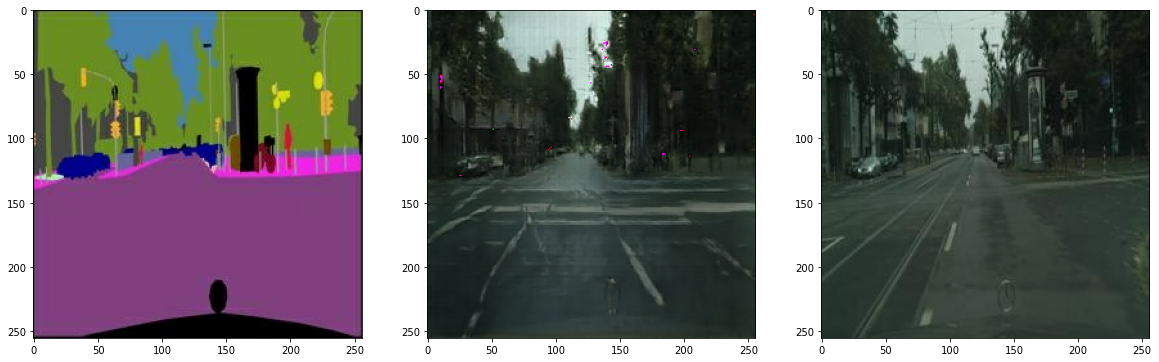

In [25]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))